In [1]:
import pandas as pd
# from modin.config import Engine
# Engine.put("ray")
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mticker
import matplotlib
import matplotlib.dates as mdates
import numpy as np
import logging
import re
from joblib import Parallel, delayed
import gensim
import gensim.downloader
import gc
import collections
import optuna

optuna.logging.set_verbosity(optuna.logging.ERROR)
logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger('nlp')
logger.setLevel(logging.INFO)

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except:
    logger.info('Intel(R) Extension for Scikit-learn* wasn\'t patched.')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import BatchSampler, RandomSampler
from torch.optim.lr_scheduler import ExponentialLR

from torchmetrics import AUROC, Accuracy, F1Score, ConfusionMatrix

sns.set(font_scale=1.4)
sns.set_style('whitegrid')

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
train_data = pd.read_csv('archive/train.csv')
valid_data = pd.read_csv('archive/valid.csv')

In [3]:
def date_to_datetime(arg):
    return datetime.strptime(arg, '%Y-%m-%d %H:%M:%S')

In [4]:
train_data['CreationDate'] = train_data['CreationDate'].map(date_to_datetime)
train_data.sort_values('Y', inplace=True)
train_data

,Id,Title,Body,Tags,CreationDate,Y
22972,45310925,How to get a complete topic distribution for a...,<p>When I train my lda model as such</p>\n\n<p...,<python><gensim><lda>,2017-07-25 18:21:31,HQ
10972,39634954,nvm uninstall doesn't actually uninstall the n...,<p>So I'm trying to clear out older versions o...,<node.js><nvm>,2016-09-22 09:16:33,HQ
10974,39635861,Unable to contact local DTServiceHub to bless ...,<p>When I run my basic Xcode project in simula...,<ios><xcode8>,2016-09-22 09:54:23,HQ
10975,39637588,C# How to add a property setter in derived class?,<p>I have a requirement where I have a number ...,<c#><inheritance>,2016-09-22 11:19:19,HQ
10976,39637675,What is the difference between @types.coroutin...,<p>Documentations say:</p>\n\n<blockquote>\n ...,<python><asynchronous><python-3.5>,2016-09-22 11:23:13,HQ
...,...,...,...,...,...,...
31785,50165626,dice number showing with c# on unity 3d,I wrote a code to show the number of the dice ...,<c#><unity3d><3d>,2018-05-04 00:50:45,LQ_EDIT
31784,50163974,powershell generate word list from two csv fil...,I'm trying to use powershell to import two csv...,<powershell><csv>,2018-05-03 21:16:52,LQ_EDIT
13573,40687487,Why this regex is not working?,Test URL:\r\n\r\n www-test1.examples.com\r\...,<java><regex>,2016-11-18 23:28:06,LQ_EDIT
31792,50172042,installing packag (gahgu95av2.db) in R,I have a problem with installing pack (gahgu95...,<r>,2018-05-04 09:48:05,LQ_EDIT


In [5]:
valid_data['CreationDate'] = valid_data['CreationDate'].map(date_to_datetime)
valid_data.sort_values('Y', inplace=True)
valid_data

,Id,Title,Body,Tags,CreationDate,Y
5708,42226798,Remove duplicate data from query results,<p>I have the following query:</p>\n\n<pre><co...,<sql-server><tsql>,2017-02-14 12:56:30,HQ
5841,42394999,Why should I use Validators.compose()?,<p>I have a field I want to validate with mult...,<angular><angular2-forms><angular2-formbuilder>,2017-02-22 14:59:19,HQ
5839,42393545,"How to fix ""Missing Gradle project configurati...","<p>As an Eclipse user, I always liked the Grad...",<eclipse><gradle><configuration><buildship>,2017-02-22 13:58:32,HQ
5838,42390860,Configure active profile in SpringBoot via Maven,<p>I'm trying to set an active profile in Spri...,<java><spring><maven><spring-boot>,2017-02-22 12:01:00,HQ
5836,42389649,'openURL' was deprecated in iOS 10.0: Please u...,<p>I have working open webLink url codes in <c...,<ios><uiwebview><swift3>,2017-02-22 11:12:41,HQ
...,...,...,...,...,...,...
8218,46154987,How avoid recurrent code in block with ruby ?,I try to convert a bash script in a ruby scrip...,<ruby><linux>,2017-09-11 11:45:53,LQ_EDIT
8217,46150920,What is the best way (steps) to implement User...,Trying to use Apache Ignite as in-memory datab...,<java><ignite>,2017-09-11 08:06:24,LQ_EDIT
8214,46147329,Converting lower case hex to uppercase in python,Can anyone please help me in converting a hex ...,<python><string><mac-address>,2017-09-11 02:13:22,LQ_EDIT
8252,46189292,I want to get $username variable from profile....,This is my ajax code:\r\n \r\n\r\n\r\n\r\n ...,<javascript><php><mysql><ajax><fetch>,2017-09-13 05:10:39,LQ_EDIT


# EDA

## Labels distribution

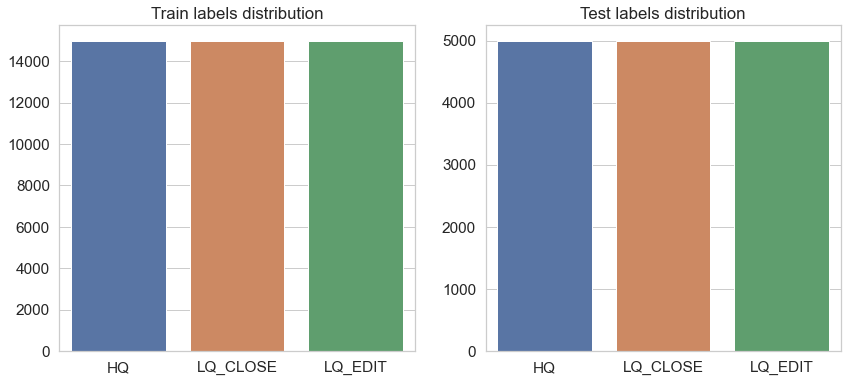

In [6]:
train_Y_vc = train_data['Y'].value_counts()
valid_Y_vc = valid_data['Y'].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=train_Y_vc.index, y=train_Y_vc.values, ax=axes[0])
axes[0].set_title('Train labels distribution')
sns.barplot(x=valid_Y_vc.index, y=valid_Y_vc.values, ax=axes[1])
axes[1].set_title('Test labels distribution')
plt.show()

#### Summary
 - Counts of labels are equal each other for both train and test datasets
 - Train dataset 3x times larger than test

In [7]:
datasets = [('Train', train_data), ('Test', valid_data)]

## Dates distribution

### Days distribution

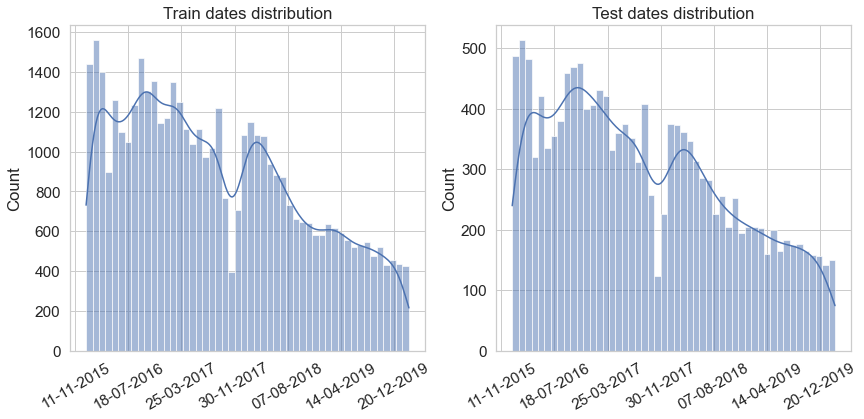

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate'].sort_values()
    def get_date(arg):
        return arg.date()
    CD_data_mapped = CD_data.map(get_date)
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

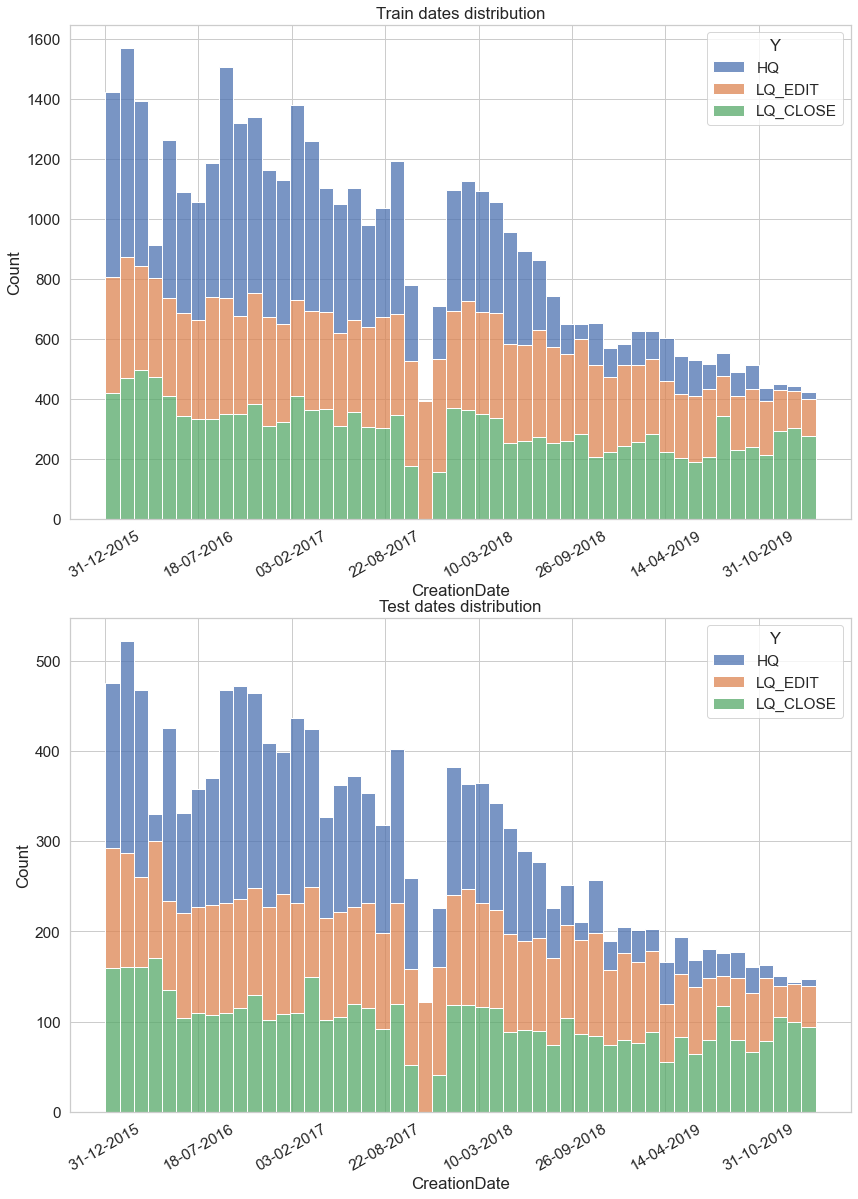

In [9]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']
anomaly_timeframes = {}

def search_anomaly_timeframe_bounds(CD_data):
    max_length = 0
    current_length = 0
    is_in_sector = False
    start_sector_idx = None
    max_start_sector_idx = None
    max_finish_sector_idx = None
    CD_data = CD_data.copy()
    for index, row in CD_data.iterrows():
        if row['Y'] == 'LQ_EDIT':
            if is_in_sector:
                current_length += 1
            else:
                is_in_sector = True
                current_length = 1
                start_sector_idx = index
        else:
            if current_length > max_length:
                max_length = current_length
                max_start_sector_idx = start_sector_idx
                max_finish_sector_idx = index
            is_in_sector = False
    return CD_data['CreationDate'][max_start_sector_idx], CD_data['CreationDate'][max_finish_sector_idx]
    
fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    CD_data.sort_values(by=['CreationDate'], inplace=True)
    anomaly_timeframes[dataset_name] = search_anomaly_timeframe_bounds(CD_data)
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx], 
                 palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

In [10]:
print('Timeframes with only LQ_EDIT samples:')
for key, value in anomaly_timeframes.items():
    print(f'{key} dataset : [{value[0]}, {value[1]}]')

Timeframes with only LQ_EDIT samples:
Train dataset : [2017-10-17 08:06:29, 2017-12-15 16:32:28]
Test dataset : [2017-10-17 05:57:57, 2017-12-15 18:01:33]


#### Summary
 - The graphs show the decrease in the number of HQ labels over time
 - Timeframe with only LQ_EDIT exists in both train and test datasets

### Daytimes distribution

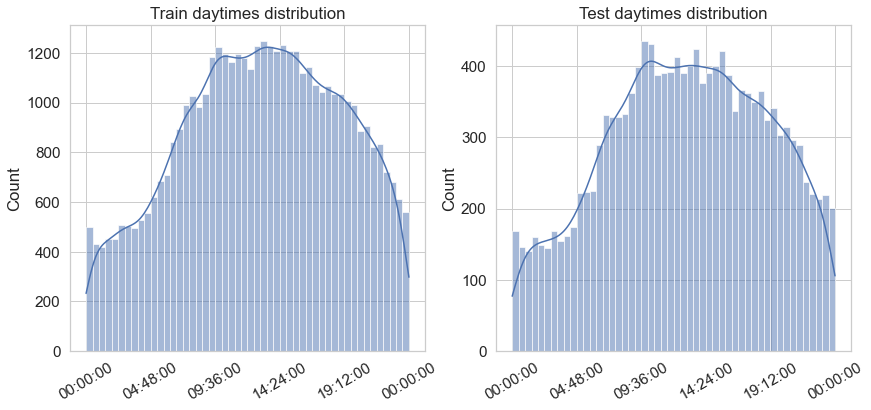

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate']
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data_mapped = CD_data.map(get_daytime).sort_values()
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

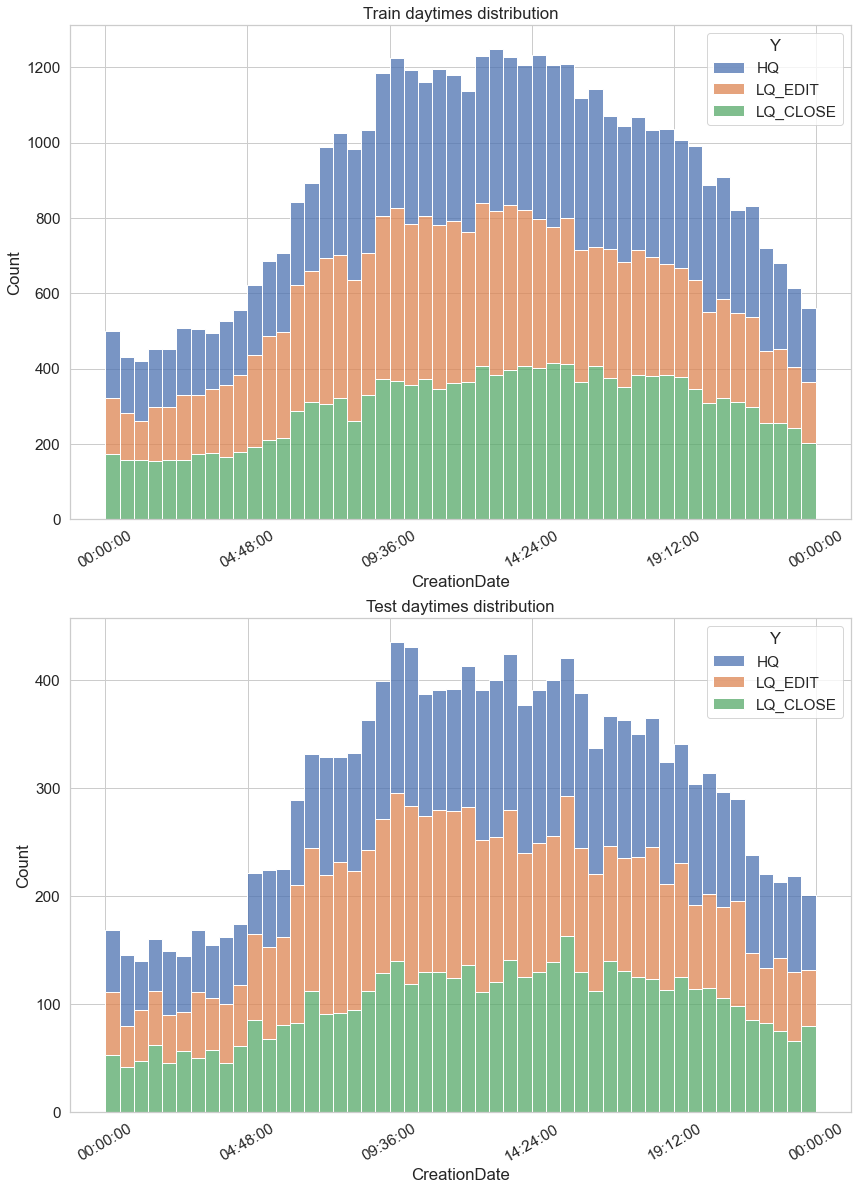

In [12]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data['CreationDate'] = CD_data['CreationDate'].map(get_daytime)
    CD_data.sort_values(by=['CreationDate'])
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

#### Summary
 - No insights

## Tags
### Find intersection of train and test datasets

In [13]:
def get_tags_counts(T_data):
    tags_dict = {}
    for item in T_data:
        if item[0] != '<' or item[-1] != '>':
            logger.error(f'Wrong format of tag: {item}')
            sys.exit(1)
        local_tags = item[1:-1].split('><')
        local_tags_set = set()
        for local_tag in local_tags:
            if local_tag in local_tags_set:
                continue
            local_tags_set.add(local_tag)
            if local_tag not in tags_dict.keys():
                tags_dict[local_tag] = 0
            tags_dict[local_tag] += 1
    return dict(sorted(tags_dict.items(), key=lambda item: -item[1]))

tags_dicts = {}
overall_keys = None

for idx, (dataset_name, dataset) in enumerate(datasets):
    T_data = dataset['Tags'].copy()
    tags_counts = get_tags_counts(T_data)
    print(f'Top 5 tags ({dataset_name} dataset):', sorted(tags_counts.items(), key=lambda item: -item[1])[:5])
    print(f'Tags count ({dataset_name} dataset):', len(tags_counts.keys()))
    tags_dicts[dataset_name] = tags_counts
    
overall_keys = tags_dicts['Train'].keys() & tags_dicts['Test'].keys()
print('Size of tags intersection on Train & Test datasets:', 
      len(overall_keys))

Top 5 tags (Train dataset): [('javascript', 5385), ('python', 5041), ('java', 4677), ('android', 3573), ('c#', 3137)]
Tags count (Train dataset): 9336
Top 5 tags (Test dataset): [('python', 1759), ('javascript', 1721), ('java', 1565), ('android', 1265), ('php', 1036)]
Tags count (Test dataset): 5401
Size of tags intersection on Train & Test datasets: 4034


### Get "tag X class" counts

In [14]:
overall_tags = []
overall_tags_df = {}

def init_stage_overall_tags():
    stage_overall_tags = {}
    for key in overall_keys:
        stage_overall_tags[key] = {}
        stage_overall_tags[key]['HQ'] = 0
        stage_overall_tags[key]['LQ_EDIT'] = 0
        stage_overall_tags[key]['LQ_CLOSE'] = 0
    return stage_overall_tags
    
for idx, (dataset_name, dataset) in enumerate(datasets):
    overall_tags.append(init_stage_overall_tags())
    stage_overall_tags = overall_tags[-1]
    T_data = dataset[['Tags', 'Y']].copy()
    for index, row in T_data.iterrows():
        tags = set(row['Tags'][1:-1].split('><'))
        for tag in tags:
            if tag in overall_keys:
                stage_overall_tags[tag][row['Y']] += 1
    overall_tags_df[dataset_name] = pd.DataFrame.from_dict(stage_overall_tags, orient='index')
    print(f'{dataset_name} tags:')
    print(overall_tags_df[dataset_name])
    

Train tags:
                        HQ  LQ_EDIT  LQ_CLOSE
portability              1        1         0
video-streaming          3        0         3
ms-access-2010           0        4         1
query-string             1        3         1
nsdictionary             1        3         6
...                     ..      ...       ...
ps                       0        0         1
azure-active-directory  12        1         2
remote-debugging         7        1         0
hiveql                   1        2         0
chef-infra               0        7         1

[4034 rows x 3 columns]
Test tags:
                        HQ  LQ_EDIT  LQ_CLOSE
portability              1        0         1
video-streaming          3        1         1
ms-access-2010           0        1         1
query-string             0        1         1
nsdictionary             0        1         4
...                     ..      ...       ...
ps                       0        0         1
azure-active-directory   2      

### Get quantiles of tags counts distribution

In [15]:
for idx, (dataset_name, dataset) in enumerate(datasets):
    def sum_counts(row):
        return sum(row.values[:3])
    tags_counts = overall_tags_df[dataset_name].apply(sum_counts, axis=1)
    overall_tags_df[dataset_name]['Sum'] = tags_counts
    print(overall_tags_df[dataset_name])
    q = tags_counts.quantile(np.linspace(0.9,1,9))
    print(f'{dataset_name} quantiles')
    print(q)

                        HQ  LQ_EDIT  LQ_CLOSE  Sum
portability              1        1         0    2
video-streaming          3        0         3    6
ms-access-2010           0        4         1    5
query-string             1        3         1    5
nsdictionary             1        3         6   10
...                     ..      ...       ...  ...
ps                       0        0         1    1
azure-active-directory  12        1         2   15
remote-debugging         7        1         0    8
hiveql                   1        2         0    3
chef-infra               0        7         1    8

[4034 rows x 4 columns]
Train quantiles
0.9000      32.0000
0.9125      37.0000
0.9250      45.0000
0.9375      55.9375
0.9500      71.0000
0.9625      95.7625
0.9750     154.0000
0.9875     282.7625
1.0000    5385.0000
dtype: float64
                        HQ  LQ_EDIT  LQ_CLOSE  Sum
portability              1        0         1    2
video-streaming          3        1         1    5

### Summary
 - Most part of tags appear rare. Others appear very often.

### Get good & rare tags

In [16]:
# Drop extra tags for visualization. count_limit provide opportunity to drop rare tags.
count_limit = 200

local_train_data = overall_tags_df['Train']
good_tags_index = local_train_data[local_train_data['Sum'] > count_limit]
rare_tags_index = local_train_data[local_train_data['Sum'] <= count_limit]
print('Good tags')
print(good_tags_index)
print('Tags at all:', sum(good_tags_index['Sum'].values))
good_tags_index = good_tags_index.index
print()
print('Rare tags')
print(rare_tags_index)
print('Tags at all:', sum(rare_tags_index['Sum'].values))
rare_tags_index = rare_tags_index.index

Good tags
                      HQ  LQ_EDIT  LQ_CLOSE   Sum
amazon-web-services  245       33        31   309
asp.net               99      137       115   351
visual-studio        138       74        75   287
visual-studio-code   208        8         9   225
loops                 13      123       100   236
...                  ...      ...       ...   ...
angular              839      137       120  1096
sql-server            59      622       111   792
docker               437       18        12   467
function              21      121       142   284
ruby                  67      211        98   376

[75 rows x 4 columns]
Tags at all: 63413

Rare tags
                        HQ  LQ_EDIT  LQ_CLOSE  Sum
portability              1        1         0    2
video-streaming          3        0         3    6
ms-access-2010           0        4         1    5
query-string             1        3         1    5
nsdictionary             1        3         6   10
...                     ..     

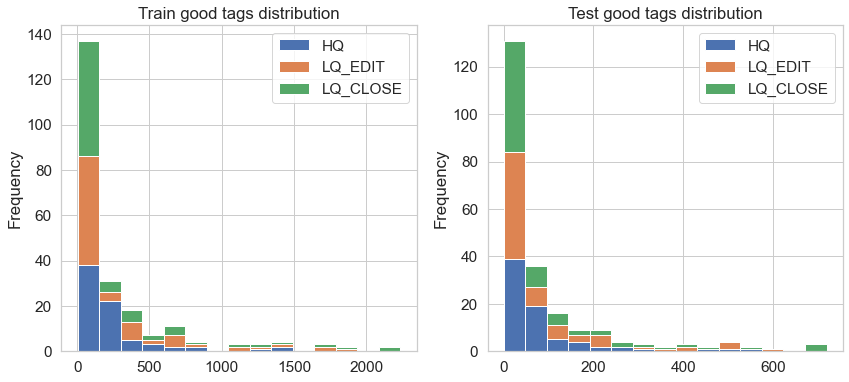

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[good_tags_index]
    tags_x_class.plot.hist(bins=15, stacked='True', title=f'{dataset_name} good tags distribution', ax=axes[idx])

In [18]:
good_tags_index

Index(['amazon-web-services', 'asp.net', 'visual-studio', 'visual-studio-code',
       'loops', 'java', 'asp.net-mvc', 'kotlin', 'angularjs', 'css', 'jquery',
       'mysql', 'json', 'sorting', 'windows', 'oracle', 'c++', 'sql', 'linux',
       'php', 'django', 'javascript', 'tensorflow', 'flutter', 'spring-boot',
       'regex', 'bash', 'git', 'webpack', 'ios', 'date', 'wordpress',
       'android-studio', 'html', 'for-loop', 'python-3.x', 'python', 'vue.js',
       'algorithm', 'selenium', 'dictionary', 'spring', 'string', 'list',
       'python-2.7', 'excel', 'pandas', 'node.js', 'reactjs', 'asp.net-core',
       'swift', 'react-native', 'laravel', 'vba', 'firebase', 'objective-c',
       'arrays', 'xcode', 'typescript', 'xml', 'c#', 'database', 'r', 'c',
       'ajax', '.net', 'if-statement', 'android', 'ruby-on-rails', 'go',
       'angular', 'sql-server', 'docker', 'function', 'ruby'],
      dtype='object')

### Analyse rare tags with Gini coef
https://en.wikipedia.org/wiki/Gini_coefficient

In [19]:
def gini_coef(coefs):
    s = sum(coefs)
    arith_mean = s / len(coefs)
    acc = 0
    for i in coefs:
        for j in coefs:
            acc += abs(i - j)
    acc /= (2 * len(coefs) ** 2 * arith_mean)
    return acc

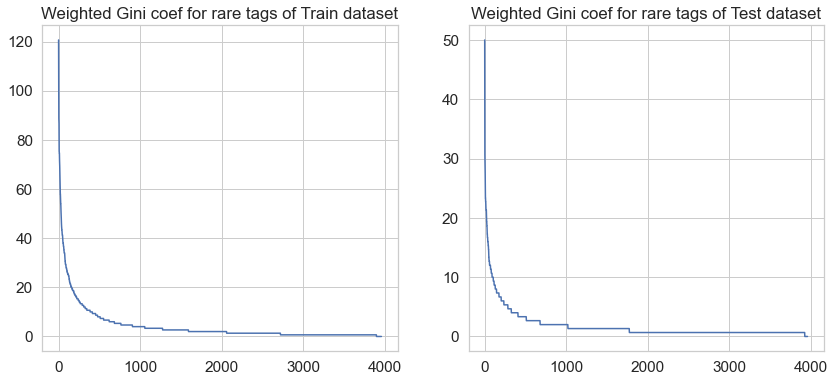

In [20]:
# To prevent overfitting on very-very rare tags we'll multiply Gini coef on sum of coefs
def weighted_gini_coef(coefs):
    return gini_coef(coefs) * sum(coefs)

rare_tags = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[rare_tags_index]
    rare_tags_scores = tags_x_class.apply(weighted_gini_coef, axis=1).sort_values(ascending=False)
    sns.lineplot(data=rare_tags_scores.values, ax=axes[idx])
    axes[idx].set_title(f'Weighted Gini coef for rare tags of {dataset_name} dataset')
    rare_tags[dataset_name] = rare_tags_scores

### Analyze Train over Test Gini coef relations

In [21]:
def analyze_gini_relations(count_limit=1e9):
    gini_relations = []
    fig, ax = plt.subplots(figsize=(7, 6))
    print('Actual train Gini coefs')
    print(rare_tags['Train'])
    limit_idx = 0
    for tag in rare_tags['Train'].index:
        if limit_idx >= count_limit:
            break
        limit_idx += 1
        train_tag_scores = rare_tags['Train'].loc[tag]
        test_tag_scores = rare_tags['Test'].loc[tag]
        if (train_tag_scores != 0 and test_tag_scores != 0):
            gini_relations.append(train_tag_scores / test_tag_scores)
    sns.scatterplot(data=gini_relations, ax=ax, alpha=0.7)
    print()
    print('Quantiles')
    print(pd.DataFrame(gini_relations).quantile([0.1, 0.25, 0.5, 0.75, 0.9, 1]))
    return 

Actual train Gini coefs
dart                     120.666667
npm                      102.666667
.net-core                 91.333333
kubernetes                88.666667
vb.net                    87.333333
                            ...    
std-function               0.000000
callkit                    0.000000
matrix-multiplication      0.000000
vagrant-windows            0.000000
filestream                 0.000000
Length: 3959, dtype: float64

Quantiles
             0
0.10  2.393429
0.25  2.651116
0.50  3.161458
0.75  3.684028
0.90  4.107237
1.00  6.833333


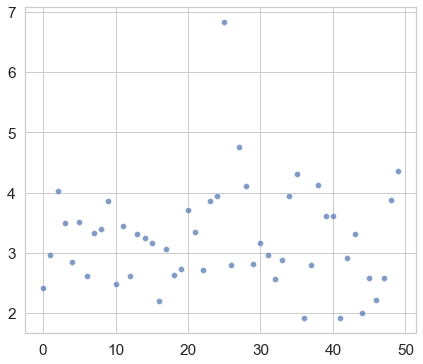

In [22]:
analyze_gini_relations(50)

### Summary
 - At least first 50 rare tags have non-uniform distribution on classes (for both train and test datasets)

Actual train Gini coefs
dart                     120.666667
npm                      102.666667
.net-core                 91.333333
kubernetes                88.666667
vb.net                    87.333333
                            ...    
std-function               0.000000
callkit                    0.000000
matrix-multiplication      0.000000
vagrant-windows            0.000000
filestream                 0.000000
Length: 3959, dtype: float64

Quantiles
              0
0.10   2.191234
0.25   2.587010
0.50   3.177083
0.75   3.866477
0.90   4.516667
1.00  15.333333


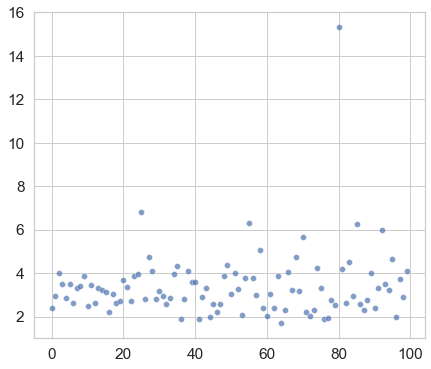

In [23]:
analyze_gini_relations(100)

Actual train Gini coefs
dart                     120.666667
npm                      102.666667
.net-core                 91.333333
kubernetes                88.666667
vb.net                    87.333333
                            ...    
std-function               0.000000
callkit                    0.000000
matrix-multiplication      0.000000
vagrant-windows            0.000000
filestream                 0.000000
Length: 3959, dtype: float64

Quantiles
         0
0.10   1.0
0.25   1.0
0.50   2.0
0.75   3.0
0.90   4.5
1.00  26.0


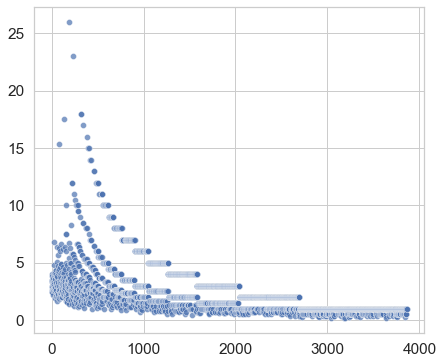

In [24]:
analyze_gini_relations()

In [25]:
interesting_rare_indices = rare_tags['Train'].index[:50]

In [26]:
interesting_rare_indices

Index(['dart', 'npm', '.net-core', 'kubernetes', 'vb.net', 'gradle',
       'ecmascript-6', 'macos', 'winforms', 'docker-compose', 'intellij-idea',
       'unit-testing', 'redux', 'google-chrome', 'jenkins', 'tsql', 'pointers',
       'perl', 'keras', 'vuejs2', 'math', 'postgresql', 'github', 'batch-file',
       'visual-studio-2017', 'apache-spark', 'object', 'numpy', 'variables',
       'swiftui', 'class', 'dockerfile', 'file', 'mysqli', 'rxjs', 'c++17',
       'azure', 'arraylist', 'jupyter-notebook', 'csv', 'angular-cli', 'web',
       'amazon-s3', 'matlab', 'sqlite', 'wpf', 'codeigniter', 'mongodb',
       'swift3', 'random'],
      dtype='object')

## Text processing

### Throw out extra symbols!

In [27]:
def remove_html_tags(text):
    html_detector = re.compile(r'<.*?>')
    return html_detector.sub(r'', text)

def remove_links(text):
    links_remover = re.compile(r'https?://\S+|www\.\S+')
    return links_remover.sub(r'', text)

#split_symbols = '\n| |{|}|\(|\)|\[|\]|\,|\.|\[^e]-[^0-9]|\=|\+|\*|\?'
split_symbols = '[^A-Za-z]'

def preprocess_body(body):
    body = remove_html_tags(body)
    body = remove_links(body)
    body = body.replace('&gt;', '>').replace('&lt;', '<').replace('&le;', '<=').replace('&ge;', '>=')
    splitted = re.split(split_symbols, body)
    result = []
    for part in splitted:
        if len(part.strip()) > 0:
            result.append(part)
    return result

def preprocess_title(title):
    title = remove_links(title)
    splitted = re.split(split_symbols, title)
    result = []
    for part in splitted:
        if len(part.strip()) > 0:
            result.append(part)
    return result

In [28]:
bodies = {}
titles = {}
label_map={'HQ': 0, 'LQ_EDIT': 1, 'LQ_CLOSE': 2}
reverse_label_map={0: 'HQ', 1: 'LQ_EDIT', 2: 'LQ_CLOSE'}

for idx, (dataset_name, dataset) in enumerate(datasets):
    bodies[dataset_name] = {}
    titles[dataset_name] = {}
    for idx, row in dataset.iterrows():
        processed_body = preprocess_body(row['Body'])
        processed_title = preprocess_title(row['Title'])
        if len(processed_body) == 0 or len(processed_title) == 0:
            continue
        bodies[dataset_name][idx] = (processed_body, label_map[row['Y']])
        titles[dataset_name][idx] = (processed_title, label_map[row['Y']])
            

### Text lengths distribution

In [29]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

Quantiles Train
      Lengths
0.10     29.0
0.25     46.0
0.50     78.0
0.75    133.0
0.99    668.0
1.00   3562.0
Quantiles Test
      Lengths
0.10    30.00
0.25    46.00
0.50    79.00
0.75   134.00
0.99   688.02
1.00  4826.00


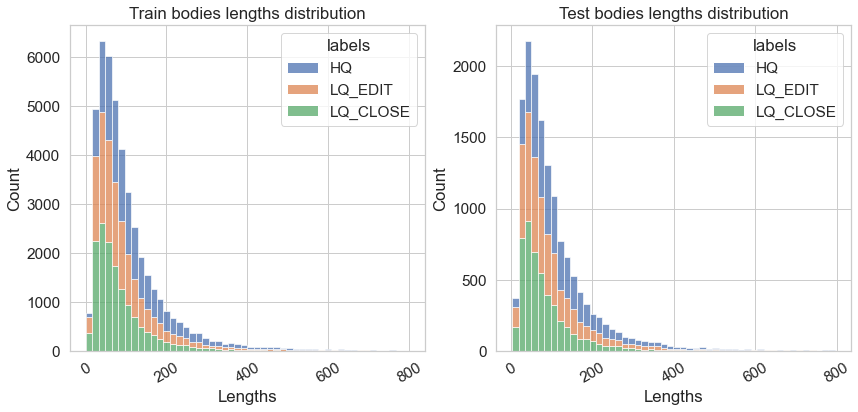

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
target_dict = bodies

for idx, (dataset_name, dataset) in enumerate(datasets):
    lengths = []
    labels = []
    for key, value in target_dict[dataset_name].items():
        lengths.append(len(value[0]))
        labels.append(reverse_label_map[value[1]])
    df = pd.DataFrame(data={'Lengths': lengths, 'labels': labels})
    print(f'Quantiles {dataset_name}')
    print(df.quantile([0.1, 0.25, 0.5, 0.75, 0.99, 1]))
    df = df[df['Lengths'] < 800]
    sns.histplot(data=df, x='Lengths', bins=50, multiple='stack', hue='labels', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} bodies lengths distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)

Quantiles
      Lengths
0.10      5.0
0.25      6.0
0.50      9.0
0.75     11.0
0.99     23.0
1.00     35.0
Quantiles
      Lengths
0.10      5.0
0.25      6.0
0.50      9.0
0.75     11.0
0.99     23.0
1.00     32.0


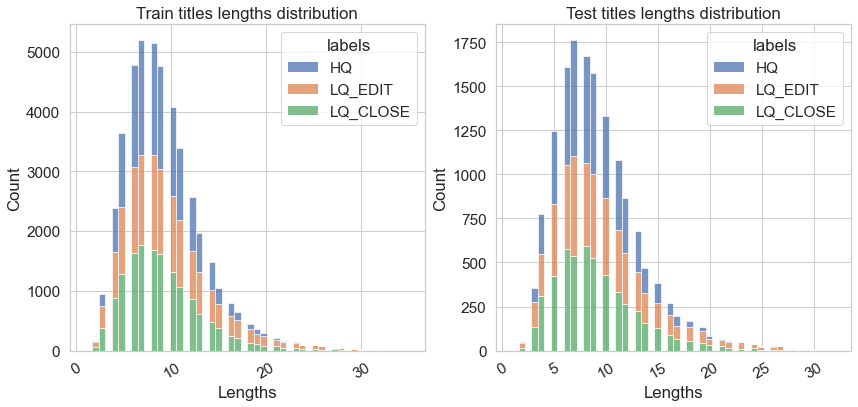

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
target_dict = titles

for idx, (dataset_name, dataset) in enumerate(datasets):
    lengths = []
    labels = []
    for key, value in target_dict[dataset_name].items():
        lengths.append(len(value[0]))
        labels.append(reverse_label_map[value[1]])
    df = pd.DataFrame(data={'Lengths': lengths, 'labels': labels})
    print('Quantiles')
    print(df.quantile([0.1, 0.25, 0.5, 0.75, 0.99, 1]))
    df = df[df['Lengths'] < 40]
    sns.histplot(data=df, x='Lengths', bins=50, multiple='stack', hue='labels', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} titles lengths distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)

# Let's find answers

**Through AI and classical NLP approaches**

## Charts plotter

**Common functionality to evaluate results of algorithm**

In [32]:
def plot_metrics(metrics_list, titles, metric_to_compare, drop_last=False):
    metrics_count = len(metrics_list)
    fig, axes = plt.subplots(metrics_count, 1, figsize=(10, 6*metrics_count))
    for idx, metrics in enumerate(metrics_list):
        reduced_dict = {}
        for stage_name, stage in metrics.items():
            reduced_dict[stage_name] = stage[metric_to_compare]
        metrics_df = pd.DataFrame.from_dict(reduced_dict)
        if drop_last:
            metrics_df.drop(df.tail(n).index,inplace=True)
        sns.lineplot(data=metrics_df, ax=axes[idx])
        axes[idx].set_title(titles[idx])

# XGBoost/RandomForest/kNN with Bag-of-words/Tfidf

In [33]:
def get_tags_dataframe(dataset, keys, tags_index, dtype):
    tags_lines = []
    tags_index_set = set(tags_index.values)
    for idx in keys:
        local_tags_str = dataset['Tags'].iloc[idx]
        local_tags = set(local_tags_str[1:-1].split('><'))
        tags_line = np.zeros(len(tags_index), dtype=dtype)
        for tag_idx, tag in enumerate(tags_index.values):
            tags_line[tag_idx] = 1. if tag in local_tags else 0.
        tags_lines.append(tags_line)
    return pd.DataFrame(data=tags_lines, columns=tags_index.values, dtype=dtype)
    
def get_time_column(dataset, keys, time_rough_mean, time_mean, time_std, dtype):
    time_lines = []
    for idx in keys:
        item = dataset['CreationDate'].iloc[idx].value
        item -= time_rough_mean
        item -= time_mean
        item /= time_std
        time_lines.append([item])
    return pd.DataFrame(time_lines, columns=['Time'], dtype=dtype)

# TODO analyse correlations of rare words with labels
# todo use insights from Time EDA
def prepare_data_pandas(dataset, titles, bodies, good_tags_index, interesting_rare_indices, dtype, vectorizer, precomputed=None):
    titles = collections.OrderedDict(sorted(titles.items()))
    bodies = collections.OrderedDict(sorted(bodies.items()))
    if not precomputed:
        precomputed = {}
        is_train = True
    else:
        is_train = False
    if is_train:
        time_values = []
        for idx in bodies.keys():
            item = dataset['CreationDate'].iloc[idx].value
            time_values.append(item)
        time_rough_mean = sum(time_values) // len(time_values)
        precomputed['time_rough_mean'] = time_rough_mean
        for idx in range(len(time_values)):
            time_values[idx] -= time_rough_mean
        numpy_time_values = np.array(time_values, dtype=dtype)
        precomputed['time_mean'] = numpy_time_values.mean()
        precomputed['time_std'] = np.std(numpy_time_values)
        
    time_rough_mean = precomputed['time_rough_mean']
    time_mean = precomputed['time_mean']
    time_std = precomputed['time_std']
    if is_train:
        vectorizer_titles = vectorizer(min_df=0.005)
        titles_list = [' '.join(title_line[0]) for title_line in titles.values()]
        X_titles = vectorizer_titles.fit_transform(titles_list)
        title_columns = ['t_'+name for name in vectorizer_titles.get_feature_names_out()]
        X_titles_df = pd.DataFrame(X_titles.toarray(), columns=title_columns, dtype=dtype)
        vectorizer_bodies = vectorizer(min_df=0.005)
        bodies_list = [' '.join(body_line[0]) for body_line in bodies.values()]
        X_bodies = vectorizer_bodies.fit_transform(bodies_list)
        body_columns = ['b_'+name for name in vectorizer_bodies.get_feature_names_out()]
        X_bodies_df = pd.DataFrame(X_bodies.toarray(), columns=body_columns, dtype=dtype)
        precomputed['vectorizer_titles'] = vectorizer_titles
        precomputed['vectorizer_bodies'] = vectorizer_bodies
    else:
        vectorizer_titles = precomputed['vectorizer_titles']
        titles_list = [' '.join(title_line[0]) for title_line in titles.values()]
        X_titles = vectorizer_titles.transform(titles_list)
        title_columns = ['t_'+name for name in vectorizer_titles.get_feature_names_out()]
        X_titles_df = pd.DataFrame(X_titles.toarray(), columns=title_columns, dtype=dtype)
        vectorizer_bodies = precomputed['vectorizer_bodies']
        bodies_list = [' '.join(body_line[0]) for body_line in bodies.values()]
        X_bodies = vectorizer_bodies.transform(bodies_list)
        body_columns = ['b_'+name for name in vectorizer_bodies.get_feature_names_out()]
        X_bodies_df = pd.DataFrame(X_bodies.toarray(), columns=body_columns, dtype=dtype)
    good_tags_df = get_tags_dataframe(dataset, titles.keys(), good_tags_index, dtype)
    rare_tags_df = get_tags_dataframe(dataset, titles.keys(), interesting_rare_indices, dtype)
    time_df = get_time_column(dataset, titles.keys(), time_rough_mean, time_mean, time_std, dtype)
    data = X_titles_df.join(X_bodies_df).join(good_tags_df).join(rare_tags_df).join(time_df)
    
    labels_lines = []
    for idx, sample in titles.items():
        item = sample[1]
        labels_lines.append([item])
    labels = pd.DataFrame(labels_lines, columns=['Label'], dtype=dtype)
    gc.collect()
    return data, labels, precomputed


## Train ML with BOW/Tfidf

In [34]:
def train_ml_pandas(train_bow_data, train_bow_labels, test_bow_data, test_bow_labels, vectorizer):
    def objective(trial, X, y, X_test, y_test):
        classifier_str = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost', 'kNN', 'LogReg'])
        if classifier_str == 'RandomForest':
            n_estimators = trial.suggest_int('n_estimators', 16, 64)
            max_depth = trial.suggest_int('max_depth', 2, 12)
            alg = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        elif classifier_str == 'kNN':
            n_neighbors = trial.suggest_int('n_neighbors', 2, 128)
            algorithm = 'brute'
            alg = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm)
        elif classifier_str == 'LogReg':
            C = trial.suggest_float('C', 1e-4, 1e5, log=True)
            alg = LogisticRegression(C=C)
        elif classifier_str == 'SVC':
            kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])
            gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
            C = trial.suggest_float('C', 1e-4, 1e5, log=True)
            alg = SVC(kernel=kernel, gamma=gamma, C=C, probability=True)
        elif classifier_str == 'XGBoost':
            n_estimators = trial.suggest_int('n_estimators', 8, 64)
            max_depth = trial.suggest_int('max_depth', 2, 12)
            alg = xgb.XGBClassifier(objective='multi:softprob', learning_rate=0.1, 
                                    n_estimators=n_estimators, max_depth=max_depth, 
                                    n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
        else:
            raise Exception('Optuna usage: Unknows classifier name.')
        alg.fit(X, y['Label'].values)
        test_probs = alg.predict_proba(X_test)
        score = f1_score(y_test, np.argmax(test_probs, axis=1), average='macro')
        gc.collect()
        return score
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, train_bow_data, train_bow_labels, test_bow_data, test_bow_labels), n_trials=128, n_jobs=1)
    logger.info(f'ML part fitting. Best score: {study.best_value}, best params: {study.best_params}')
    classifier_classname = study.best_params['classifier']
    if classifier_classname == 'RandomForest':
        classifier_class = RandomForestClassifier
    elif classifier_classname == 'kNN':
        classifier_class = KNeighborsClassifier
    elif classifier_classname == 'XGBoost':
        classifier_class = xgb.XGBClassifier
    elif classifier_classname == 'LogReg':
        classifier_class = LogisticRegression
    elif classifier_classname == 'SVC':
        classifier_class = SVC
    else:
        raise Exception('fit_ml_head: Unknows classifier name.')
    alg_params = study.best_params.copy()
    del alg_params['classifier']
    classifier = classifier_class(**alg_params)
    classifier.fit(train_bow_data, train_bow_labels['Label'].values)
    gc.collect()
    return classifier, study



## BOW with ML training

In [35]:
train_bow_data, train_bow_labels, bow_precomputed = prepare_data_pandas(train_data, titles['Train'], bodies['Train'], good_tags_index, interesting_rare_indices, dtype=np.float32, vectorizer=CountVectorizer)
test_bow_data, test_bow_labels, _ = prepare_data_pandas(valid_data, titles['Test'], bodies['Test'], good_tags_index, interesting_rare_indices, dtype=np.float32, vectorizer=CountVectorizer, precomputed=bow_precomputed)
bow_model, bow_study = train_ml_pandas(train_bow_data, train_bow_labels, test_bow_data, test_bow_labels, CountVectorizer)

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

In [36]:
bow_model

LogisticRegression(C=0.018692650765169263)

In [37]:
bow_study.best_value

0.6575779790356107

In [38]:
del train_bow_data, train_bow_labels, bow_precomputed, test_bow_data, test_bow_labels, bow_model, bow_study, _
gc.collect()

0

## Tfidf with ML training

In [39]:
train_tfidf_data, train_tfidf_labels, tfidf_precomputed = prepare_data_pandas(train_data, titles['Train'], bodies['Train'], good_tags_index, interesting_rare_indices, dtype=np.float32, vectorizer=TfidfVectorizer)
test_tfidf_data, test_tfidf_labels, _ = prepare_data_pandas(valid_data, titles['Test'], bodies['Test'], good_tags_index, interesting_rare_indices, dtype=np.float32, vectorizer=TfidfVectorizer, precomputed=tfidf_precomputed)
tfidf_model, tfidf_study = train_ml_pandas(train_tfidf_data, train_tfidf_labels, test_tfidf_data, test_tfidf_labels, TfidfVectorizer)

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/masdevas/.anaconda3/envs/nlp-unn/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

In [40]:
tfidf_model

LogisticRegression(C=2.756528281745748)

In [41]:
tfidf_study.best_value

0.6652020793737831

In [42]:
del train_tfidf_data, train_tfidf_labels, tfidf_precomputed, test_tfidf_data, test_tfidf_labels, tfidf_model, tfidf_study, _
gc.collect()

0

# Bidirectional RNN Model with FC/XGBoost/RandomForest/kNN head

## Torch, how are you?

In [43]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70
  - CuDNN 7.6.5
  - Magma 2.5.2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=10.2, CUDNN_VERSION=7.6.5, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -DUSE_KINETO -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DEDGE_PROFILER_USE_KINETO -O2 -fPI

In [44]:
torch.backends.cudnn.is_available()

True

In [45]:
torch.backends.mkldnn.is_available()

True

In [46]:
if torch.cuda.is_available():
    print(torch.cuda.device_count())

1


## Words converter for NN

In [47]:
def get_empty_word(shape, dtype, device):
    return torch.zeros(shape, dtype=dtype, device=device)

def fill_text_data(sentence_tensor, text, limit, embeddings, empty_word, dtype, device):    
    words_added = 0
    word_idx = 0
    while words_added < limit:
        if word_idx >= len(text):
            break
        word = text[word_idx]
        word_idx += 1
        if word in embeddings:
            embedding = embeddings[word]
        else:
            continue
        sentence_tensor.append(torch.tensor(embedding, dtype=dtype, device=device))
        words_added += 1
    extra_limit = limit - words_added
    for word_idx in range(extra_limit):
        sentence_tensor.append(empty_word)

def get_sentence_tensor(title, body, embeddings, empty_word, title_size, body_size, dtype, device):
    sentence_tensor = []
    fill_text_data(sentence_tensor, title, title_size, embeddings, empty_word, dtype, device)
    fill_text_data(sentence_tensor, body, body_size, embeddings, empty_word, dtype, device)
    return torch.stack(sentence_tensor, dim=0).to(device=device)

def find_sentence_statistics(corpus, embeddings):
    lengths = []
    for item in corpus.values():
        sentence = item[0]
        words_counter = 0
        for word in sentence:
            if word in embeddings:
                words_counter += 1
        lengths.append(words_counter)
    return max(lengths), sum(lengths) / len(lengths)

def get_tags_tensor(dataset, idx, tags_list, dtype, device):
    local_tags_str = dataset['Tags'].iloc[idx]
    local_tags = set(local_tags_str[1:-1].split('><'))
    tensor_line = np.zeros(len(tags_list), dtype=np.float32)
    for tag_idx, tag in enumerate(tags_list):
        tensor_line[tag_idx] = 1. if tag in local_tags else 0.
    return torch.tensor(tensor_line, dtype=dtype, device=device)
    
def get_time_tensor(dataset, idx, dtype, device, time_rough_mean, time_mean, time_std):
    item = dataset['CreationDate'].iloc[idx].value
    item -= time_rough_mean
    item -= time_mean
    item /= time_std
    return torch.tensor([item], dtype=dtype, device=device)

# sentences 
#   label_words
#   body_words
def prepare_data_tensors(dataset, titles, bodies, dtype, device, embeddings, good_tags_index, interesting_rare_indices, number_body_words_to_add, number_title_words_to_add, forced_limits=None):
    with torch.no_grad():
        titles = collections.OrderedDict(sorted(titles.items()))
        bodies = collections.OrderedDict(sorted(bodies.items()))
        tags_list = list(set.union(set(good_tags_index), set(interesting_rare_indices)))
        torch_data_list = []
        torch_labels_list = []
        extra_datas = []
        empty_word = get_empty_word(embeddings['car'].shape, dtype, device)
        title_max_length, title_avg_length = find_sentence_statistics(titles, embeddings)
        logger.info(f'Title max length: {title_max_length}, Title avg length: {title_avg_length}')
        body_max_length, body_avg_length = find_sentence_statistics(bodies, embeddings)
        logger.info(f'Body max length: {body_max_length}, Body avg length: {body_avg_length}')
        if not forced_limits:
            title_size = min(number_title_words_to_add, title_max_length)
            body_size = min(number_body_words_to_add, body_max_length)
        else:
            title_size = forced_limits['title_size']
            body_size = forced_limits['body_size']
        
        if not forced_limits:
            time_values = []
            for idx in bodies.keys():
                item = dataset['CreationDate'].iloc[idx].value
                time_values.append(item)
            time_rough_mean = sum(time_values) // len(time_values)
            for idx in range(len(time_values)):
                time_values[idx] -= time_rough_mean
            numpy_time_values = np.array(time_values, dtype=np.single)
            time_mean = numpy_time_values.mean()
            time_std = np.std(numpy_time_values)
        else:
            time_rough_mean = forced_limits['time_rough_mean']
            time_mean = forced_limits['time_mean']
            time_std = forced_limits['time_std']
        
        for idx in bodies.keys():
            sentence_tensor = get_sentence_tensor(titles[idx][0], bodies[idx][0], embeddings, empty_word, title_size, body_size, dtype, device)
            tags_tensor = get_tags_tensor(dataset, idx, tags_list, dtype, device)
            time_tensor = get_time_tensor(dataset, idx, dtype, device, time_rough_mean, time_mean, time_std)
            extra_data = torch.cat([tags_tensor, time_tensor])
            extra_datas.append(extra_data)
            torch_data_list.append(sentence_tensor)
            torch_labels_list.append(bodies[idx][1])
        data = torch.stack(torch_data_list, dim=0).to(device=device)
        extra = torch.stack(extra_datas, dim=0).to(device=device)
        labels = torch.tensor(torch_labels_list, dtype=torch.long, device=device)
        return data, extra, labels, title_size, body_size, time_rough_mean, time_mean, time_std

**Let's call it RNNML!**

In [48]:
import time

class RNNMLModel(nn.Module):
    def __init__(self, embeddings, compute_device, *, title_size, body_size, fc_size1, fc_size2, hidden_dim, embedding_dim, extra_size, dtype):
        super().__init__()
        self.dtype = dtype
        self.hidden_dim = hidden_dim
        self.embeddings = embeddings
        self.compute_device = compute_device
        self.embedding_dim = embedding_dim
        self.title_size = title_size
        self.body_size = body_size
        self.extra_size = extra_size
        self.fc_size1 = fc_size1
        self.fc_size2 = fc_size2
        self.classifier = None
        self.lstm_forward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_backward_title = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_forward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.lstm_backward_body = nn.LSTMCell(self.embedding_dim, self.hidden_dim)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        
        self.input_size = self.hidden_dim * 4 + self.extra_size
        self.lstmout_scale_factor = 1
        self.lstmout_estimation = torch.full((1, self.input_size), 0, dtype=self.dtype, device=self.compute_device)
        self.lstmout_std = torch.full((1, self.input_size,), 1, dtype=self.dtype, device=self.compute_device)
        
        self.fc1_1 = nn.Linear(self.input_size, self.fc_size1)
        self.fc1_2 = nn.Linear(self.input_size, self.fc_size1)
        self.fc1_3 = nn.Linear(self.input_size, self.fc_size1)
        self.prelu1_1 = nn.PReLU()
        self.prelu1_2 = nn.PReLU()
        self.prelu1_3 = nn.PReLU()
        self.batchnorm1_1 = nn.BatchNorm1d(self.fc_size1)
        self.batchnorm1_2 = nn.BatchNorm1d(self.fc_size1)
        self.batchnorm1_3 = nn.BatchNorm1d(self.fc_size1)
        self.fc2_1 = nn.Linear(self.fc_size1, self.fc_size2)
        self.fc2_2 = nn.Linear(self.fc_size1, self.fc_size2)
        self.fc2_3 = nn.Linear(self.fc_size1, self.fc_size2)
        self.prelu2_1 = nn.PReLU()
        self.prelu2_2 = nn.PReLU()
        self.prelu2_3 = nn.PReLU()
        self.batchnorm2_1 = nn.BatchNorm1d(self.fc_size2)
        self.batchnorm2_2 = nn.BatchNorm1d(self.fc_size2)
        self.batchnorm2_3 = nn.BatchNorm1d(self.fc_size2)
        self.fc3_1 = nn.Linear(self.fc_size2, 1)
        self.fc3_2 = nn.Linear(self.fc_size2, 1)
        self.fc3_3 = nn.Linear(self.fc_size2, 1)
        self.softmax = nn.Softmax(dim=1)

    def _get_hidden_state_for_words(self, lstm_cell, data, iterable_idx, hx_init, cx_init):
        hx = hx_init.detach().clone()
        cx = cx_init.detach().clone()
        hx_copies = [hx]
        for idx in iterable_idx:
            subdata = data[idx]
            hx, cx = lstm_cell(subdata, (hx, cx))
            hx_copies.append(hx)
        return torch.stack(hx_copies, dim=2)
    
    def _eval_part_of_hidden(self, data, hx_init, cx_init, iterable_idx, fwd_lstm_cell, bkwd_lstm_cell):
        forward_pass = self._get_hidden_state_for_words(fwd_lstm_cell, data, iterable_idx, hx_init, cx_init)
        forward_pooled = self.maxpool(forward_pass).view(-1, self.hidden_dim)
        backward_pass = self._get_hidden_state_for_words(bkwd_lstm_cell, data, reversed(iterable_idx), hx_init, cx_init)
        backward_pooled = self.maxpool(backward_pass).view(-1, self.hidden_dim)
        concat_pass = torch.cat([forward_pooled, backward_pooled], dim=1)
        return concat_pass
    
    def _eval_hidden(self, data, hx_init, cx_init):
        title_iterable_id = range(self.title_size)
        title_pass = self._eval_part_of_hidden(data, hx_init, cx_init, title_iterable_id, self.lstm_forward_title, self.lstm_backward_title)
        body_start_idx = self.title_size
        body_iterable_id = range(body_start_idx, body_start_idx + self.body_size)
        body_pass = self._eval_part_of_hidden(data, hx_init, cx_init, body_iterable_id, self.lstm_forward_body, self.lstm_backward_body)
        concat_pass = torch.cat([title_pass, body_pass], dim=1)
        return concat_pass

    def _lstm_part_forward(self, data):
        data = torch.transpose(data, 0, 1)
        hx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=self.dtype, device=self.compute_device)
        cx_init = torch.zeros(data.shape[1], self.hidden_dim, dtype=self.dtype, device=self.compute_device)
        hidden_result = self._eval_hidden(data, hx_init, cx_init)
        return hidden_result
    
    def prehead_forward(self, data, extra):
        hidden_result = self._lstm_part_forward(data)
        lstm_res = (hidden_result - self.lstmout_estimation) / self.lstmout_std * self.lstmout_scale_factor
        return torch.cat([lstm_res, extra], dim=1)
    
    # X - [batch_size, words_num, embed_dim]
    def forward(self, data, extra, mode):
        prehead_result = self.prehead_forward(data, extra)
        if mode == 'nn':
            fc1_1_res = self.fc1_1(prehead_result)
            fc1_2_res = self.fc1_2(prehead_result)
            fc1_3_res = self.fc1_3(prehead_result)

            prelu1_1_res = self.prelu1_1(fc1_1_res)
            prelu1_2_res = self.prelu1_2(fc1_2_res)
            prelu1_3_res = self.prelu1_3(fc1_3_res)

            normalized1_1_res = self.batchnorm1_1(prelu1_1_res)
            normalized1_2_res = self.batchnorm1_2(prelu1_2_res)
            normalized1_3_res = self.batchnorm1_3(prelu1_3_res)
            
            fc2_1_res = self.fc2_1(normalized1_1_res)
            fc2_2_res = self.fc2_2(normalized1_2_res)
            fc2_3_res = self.fc2_3(normalized1_3_res)
            
            prelu2_1_res = self.prelu2_1(fc2_1_res)
            prelu2_2_res = self.prelu2_2(fc2_2_res)
            prelu2_3_res = self.prelu2_3(fc2_3_res)
            
            normalized2_1_res = self.batchnorm2_1(prelu2_1_res)
            normalized2_2_res = self.batchnorm2_2(prelu2_2_res)
            normalized2_3_res = self.batchnorm2_3(prelu2_3_res)
            
            fc3_1_res = self.fc3_1(normalized2_1_res)
            fc3_2_res = self.fc3_2(normalized2_2_res)
            fc3_3_res = self.fc3_3(normalized2_3_res)
            
            head_res = torch.cat([fc3_1_res, fc3_2_res, fc3_3_res], 1)
            softmax_res = self.softmax(head_res)
            return softmax_res
        elif mode == 'ml':
            numpy_prehead_res = prehead_result.detach().cpu().numpy()
            probs = self.classifier.predict_proba(numpy_prehead_res)
            res = torch.tensor(probs, dtype=self.dtype, device=self.compute_device)
            return res
        else:
            raise Exception('forward: Wrong mode.')
        
    def recalculate_lstmout_statistics(self, data, extra):
        batch_size = 1024
        train_indices = list(BatchSampler(RandomSampler(range(data.shape[0])), 
                                         batch_size=batch_size, drop_last=False))
        x_train_list = []
        for batch_idx, batch_indices in enumerate(train_indices):
            batch_data = data[batch_indices].to(self.compute_device)
            batch_extra = extra[batch_indices].to(self.compute_device)
            x_train_list.append(self._lstm_part_forward(batch_data).detach())
        x_train = torch.cat(x_train_list)
        self.lstmout_estimation = x_train.mean(dim=0).unsqueeze(0)
        self.lstmout_std = torch.std(x_train, dim=0, keepdim=True)
        self.lstmout_std = self.lstmout_std.where(torch.abs(self.lstmout_std) >= 1e-4, torch.tensor(1, dtype=self.dtype, device=self.compute_device))
        del x_train_list
        gc.collect()
        
    def _prepare_data_for_ml(self, data, extra, labels, test_data, test_extra, test_labels):
        with torch.no_grad():
            batch_size = 1024
            train_indices = list(BatchSampler(RandomSampler(range(data.shape[0])), 
                                             batch_size=batch_size, drop_last=False))
            test_indices = list(BatchSampler(RandomSampler(range(test_data.shape[0])), 
                                             batch_size=batch_size, drop_last=False))
            numpy_x_train_list = []
            numpy_y_train_list = []
            numpy_x_test_list = []
            numpy_y_test_list = []
            for batch_idx, batch_indices in enumerate(train_indices):
                batch_data = data[batch_indices].to(self.compute_device).detach()
                batch_extra = extra[batch_indices].to(self.compute_device).detach()
                numpy_x_train_list.append(self.prehead_forward(batch_data, batch_extra).detach().cpu().numpy())
                numpy_y_train_list.append(labels[batch_indices].detach().cpu().numpy())
                del batch_data, batch_extra
                gc.collect()
                torch.cuda.empty_cache()
            for batch_idx, batch_indices in enumerate(test_indices):
                batch_data = test_data[batch_indices].to(self.compute_device).detach()
                batch_extra = test_extra[batch_indices].to(self.compute_device).detach()
                numpy_x_test_list.append(self.prehead_forward(batch_data, batch_extra).detach().cpu().numpy())
                numpy_y_test_list.append(test_labels[batch_indices].detach().cpu().numpy())
                del batch_data, batch_extra
                gc.collect()
                torch.cuda.empty_cache()

            numpy_x_train = np.concatenate(numpy_x_train_list)
            numpy_y_train = np.concatenate(numpy_y_train_list)
            numpy_x_test = np.concatenate(numpy_x_test_list)
            numpy_y_test = np.concatenate(numpy_y_test_list)
            del numpy_x_train_list, numpy_x_test_list, numpy_y_train_list, numpy_y_test_list
            gc.collect()
            return numpy_x_train, numpy_y_train, numpy_x_test, numpy_y_test
        
    def fit_ml_head(self, data, extra, labels, test_data, test_extra, test_labels, objective):
        numpy_x_train, numpy_y_train, numpy_x_test, numpy_y_test = self._prepare_data_for_ml(data, extra, labels, test_data, test_extra, test_labels)
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, numpy_x_train, numpy_y_train, numpy_x_test, numpy_y_test), n_trials=32, n_jobs=1)
        logger.info(f'ML part fitting. Best score: {study.best_value}, best params: {study.best_params}')
        classifier_classname = study.best_params['classifier']
        if classifier_classname == 'RandomForest':
            classifier_class = RandomForestClassifier
        elif classifier_classname == 'kNN':
            classifier_class = KNeighborsClassifier
        elif classifier_classname == 'XGBoost':
            classifier_class = xgb.XGBClassifier
        elif classifier_classname == 'LogReg':
            classifier_class = LogisticRegression
        else:
            raise Exception('fit_ml_head: Unknows classifier name.')
        alg_params = study.best_params.copy()
        del alg_params['classifier']
        self.classifier = classifier_class(**alg_params)

        self.classifier.fit(numpy_x_train, numpy_y_train)
        return study


## Train function definition

In [49]:
def rnnml_evaluate(data, extra, labels, model, criterion, compute_device, batch_indices, metrics, metrics_stage, mode):
    with torch.no_grad():
        accuracy_torch = Accuracy(num_classes=3, average='macro').to(compute_device)
        f1score_torch = F1Score(num_classes=3, average='macro').to(compute_device)
        confmat_torch = ConfusionMatrix(num_classes=3).to(compute_device)
        local_conf_matrices = []
        local_loss = []
        local_metrics_accuracy = []
        local_metrics_f1score = []
        for batch_idx, batch_indices in enumerate(batch_indices):
            batch_data = data[batch_indices].to(compute_device).detach()
            batch_extra = extra[batch_indices].to(compute_device).detach()
            batch_labels = labels[batch_indices].to(compute_device).detach()
            predicted = model.forward(batch_data, batch_extra, mode).detach()
            loss = criterion(predicted, batch_labels).detach()
            local_loss.append(loss.item())
            local_metrics_accuracy.append(accuracy_torch(predicted, batch_labels).item())
            local_metrics_f1score.append(f1score_torch(predicted, batch_labels).item())
            local_conf_matrices.append(confmat_torch(predicted, batch_labels).detach().cpu().numpy())
            del batch_data, batch_extra, batch_labels, predicted, loss
            gc.collect()
            torch.cuda.empty_cache()
        result_confmat = sum(local_conf_matrices)
        metrics[metrics_stage]['loss'].append(sum(local_loss) / len(local_loss))
        metrics[metrics_stage]['accuracy'].append(sum(local_metrics_accuracy) / len(local_metrics_accuracy))
        metrics[metrics_stage]['f1score'].append(sum(local_metrics_f1score) / len(local_metrics_f1score))
        metrics[metrics_stage]['confmat'].append(result_confmat.flatten())
    
def rnnml_get_latest_metrics(metrics):
    latest_metrics = {}
    for stage in ('train_nn', 'test_nn', 'train_ml', 'test_ml'):
        latest_metrics[stage] = {}
        for key, value in metrics[stage].items():
            try:
                latest_metrics[stage][key] = f'{metrics[stage][key][-1]:.3f}'
            except TypeError as e:
                latest_metrics[stage][key] = f'{str(metrics[stage][key][-1])}'
    return latest_metrics

# todo Tune grad norm factor, probably use different optimizers for RNN/nonRNN parts
# todo use insights from Time EDA
# eval weights changing for RNN/nonRNN parts (for each layer)
def rnnml_train(torch_train_data, torch_train_extra, torch_train_labels, 
          torch_test_data, torch_test_extra, torch_test_labels, 
          model_class, embeddings, epoch_count, batch_size, device, compute_device, dtype, 
          ml_fitting_freq, **kwargs):
    model = model_class(embeddings, compute_device, **kwargs, dtype=dtype).to(compute_device)
    model.recalculate_lstmout_statistics(torch_train_data, torch_train_extra)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    scheduler = ExponentialLR(optimizer, gamma=0.85, verbose=True)
    criterion = nn.CrossEntropyLoss()
    logger.info('Model was created.')
    metrics = {
        'train_nn' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        },
        'test_nn' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        }
        ,
        'train_ml' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        },
        'test_ml' : {
            'loss' : [],
            'confmat' : [],
            'accuracy' : [],
            'f1score' : []
        }
    }
    studies = []
    gc.collect()
    torch.cuda.empty_cache()
    
    def objective(trial, X, y, X_test, y_test):
        classifier_str = trial.suggest_categorical('classifier', ['RandomForest', 'XGBoost', 'kNN'])
        if classifier_str == 'RandomForest':
            n_estimators = trial.suggest_int('n_estimators', 16, 64)
            max_depth = trial.suggest_int('max_depth', 2, 12)
            alg = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
        elif classifier_str == 'kNN':
            n_neighbors = trial.suggest_int('n_neighbors', 2, 128)
            algorithm = 'brute'
            alg = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm)
        elif classifier_str == 'LogReg':
            C = trial.suggest_float('C', 1e-4, 1e5, log=True)
            alg = LogisticRegression(C=C)
        elif classifier_str == 'XGBoost':
            n_estimators = trial.suggest_int('n_estimators', 8, 64)
            max_depth = trial.suggest_int('max_depth', 2, 12)
            alg = xgb.XGBClassifier(objective='multi:softprob', learning_rate=0.1, 
                                    n_estimators=n_estimators, max_depth=max_depth, 
                                    n_jobs=-1, tree_method='gpu_hist', gpu_id=0)
        else:
            raise Exception('Optuna usage: Unknows classifier name.')
        alg.fit(X, y)
        test_probs = alg.predict_proba(X_test)
        score = f1_score(y_test, np.argmax(test_probs, axis=1), average='macro')
        gc.collect()
        return score

    for epoch in range(epoch_count):
        logger.info(f'Epoch {epoch}/{epoch_count-1} started.')

        # Train loop
        perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                         batch_size=batch_size, drop_last=False))
        for batch_idx, batch_indices in enumerate(perm_indices):
            batch_data = torch_train_data[batch_indices].to(compute_device)
            batch_extra = torch_train_extra[batch_indices].to(compute_device)
            batch_labels = torch_train_labels[batch_indices].to(compute_device)
            optimizer.zero_grad()
            predicted = model.forward(batch_data, batch_extra, 'nn')
            loss = criterion(predicted, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            del batch_data, batch_labels, batch_extra, predicted, loss
            gc.collect()
            torch.cuda.empty_cache()
        scheduler.step()
        
        gc.collect()
        torch.cuda.empty_cache()
        model.recalculate_lstmout_statistics(torch_train_data, torch_train_extra)
        
        if epoch % ml_fitting_freq == 0 or epoch + 1 == epoch_count:
            study = model.fit_ml_head(torch_train_data, torch_train_extra, torch_train_labels, 
                torch_test_data, torch_test_extra, torch_test_labels, objective)
            studies.append(study)
        gc.collect()
        torch.cuda.empty_cache()
        
        # Test on test data
        test_batch_size = 4096
        test_perm_indices = list(BatchSampler(RandomSampler(range(torch_test_data.shape[0])), 
                                         batch_size=test_batch_size, drop_last=True))
        rnnml_evaluate(torch_test_data, torch_test_extra, torch_test_labels, 
                 model, criterion, compute_device, test_perm_indices, metrics, 'test_nn', 'nn')
        
        # Test on train data
        train_batch_size = 4096
        train_perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                         batch_size=train_batch_size, drop_last=True))
        rnnml_evaluate(torch_train_data, torch_train_extra, torch_train_labels, 
                 model, criterion, compute_device, train_perm_indices, metrics, 'train_nn', 'nn')
        gc.collect()
        torch.cuda.empty_cache()
        
        if epoch % ml_fitting_freq == 0 or epoch + 1 == epoch_count:
            # Test on test data
            test_batch_size = 4096
            test_perm_indices = list(BatchSampler(RandomSampler(range(torch_test_data.shape[0])), 
                                             batch_size=test_batch_size, drop_last=True))
            rnnml_evaluate(torch_test_data, torch_test_extra, torch_test_labels, 
                     model, criterion, compute_device, test_perm_indices, metrics, 'test_ml', 'ml')

            # Test on train data
            train_batch_size = 4096
            train_perm_indices = list(BatchSampler(RandomSampler(range(torch_train_data.shape[0])), 
                                             batch_size=train_batch_size, drop_last=True))
            rnnml_evaluate(torch_train_data, torch_train_extra, torch_train_labels, 
                     model, criterion, compute_device, train_perm_indices, metrics, 'train_ml', 'ml')
        else:
            for stage in ('test_ml', 'train_ml'):
                for key, value in metrics[stage].items():
                    metrics[stage][key].append(metrics[stage][key][-1])
        gc.collect()
        torch.cuda.empty_cache()
        logger.info(f'Epoch {epoch} finished. Metrics: {rnnml_get_latest_metrics(metrics)}.')    
    
    return model, metrics, studies


## Let's train RNNML with GloVe embeddings

In [50]:
rnnml_embeddings = gensim.downloader.load('glove-twitter-100')

In [51]:
rnnml_hidden_dim = 100
rnnml_fc_size1 = 200
rnnml_fc_size2 = 100
rnnml_embedding_dim = 100
rnnml_epoch_count = 50
rnnml_batch_size = 1024
rnnml_extra_size = 126
rnnml_ml_fitting_freq = 5
rnnml_number_body_words_to_add = 90
rnnml_number_title_words_to_add = 15
rnnml_device = torch.device("cpu")
rnnml_compute_device = torch.device("cuda:0")
rnnml_dtype = torch.float32

In [52]:
rnnml_torch_train_data, rnnml_torch_train_extra, rnnml_torch_train_labels, rnnml_title_size, rnnml_body_size, time_rough_mean, time_mean, time_std = prepare_data_tensors(train_data, titles['Train'], bodies['Train'], rnnml_dtype, rnnml_device, rnnml_embeddings, good_tags_index, interesting_rare_indices, rnnml_number_body_words_to_add, rnnml_number_title_words_to_add)
logger.info('Train data was prepared.')

INFO:nlp:Title max length: 33, Title avg length: 7.0230904282507725
INFO:nlp:Body max length: 2787, Body avg length: 88.73100428917483
INFO:nlp:Train data was prepared.


In [53]:
rnnml_torch_test_data, rnnml_torch_test_extra, rnnml_torch_test_labels, _, _, _, _, _ = prepare_data_tensors(valid_data, titles['Test'], bodies['Test'], rnnml_dtype, rnnml_device, rnnml_embeddings, good_tags_index, interesting_rare_indices, rnnml_number_body_words_to_add, rnnml_number_title_words_to_add, forced_limits={'title_size' : rnnml_title_size, 'body_size' : rnnml_body_size, 'time_mean' : time_mean, 'time_std' : time_std, 'time_rough_mean' : time_rough_mean})
logger.info('Test data was prepared.')

INFO:nlp:Title max length: 31, Title avg length: 7.010600706713781
INFO:nlp:Body max length: 4415, Body avg length: 89.82805520368025
INFO:nlp:Test data was prepared.


In [54]:
rnnml_model, rnnml_metrics, rnnml_studies = rnnml_train(rnnml_torch_train_data, rnnml_torch_train_extra, rnnml_torch_train_labels, rnnml_torch_test_data, rnnml_torch_test_extra,
      rnnml_torch_test_labels, RNNMLModel, rnnml_embeddings, rnnml_epoch_count, rnnml_batch_size, rnnml_device, rnnml_compute_device, rnnml_dtype, rnnml_ml_fitting_freq,
      title_size=rnnml_title_size, body_size=rnnml_body_size, fc_size1=rnnml_fc_size1, fc_size2=rnnml_fc_size2, hidden_dim=rnnml_hidden_dim, 
      embedding_dim=rnnml_embedding_dim, extra_size=rnnml_extra_size)

INFO:nlp:Model was created.


Adjusting learning rate of group 0 to 1.0000e-01.


INFO:nlp:Epoch 0/49 started.


Adjusting learning rate of group 0 to 8.5000e-02.


INFO:nlp:ML part fitting. Best score: 0.5672209222131408, best params: {'classifier': 'XGBoost', 'n_estimators': 59, 'max_depth': 9}
INFO:nlp:Epoch 0 finished. Metrics: {'train_nn': {'loss': '1.081', 'confmat': '[9217  374 4080 4461 1250 7918 4232  777 8651]', 'accuracy': '0.466', 'f1score': '0.415'}, 'test_nn': {'loss': '1.076', 'confmat': '[2779  105 1221 1302  412 2363 1256  235 2615]', 'accuracy': '0.472', 'f1score': '0.422'}, 'train_ml': {'loss': '0.725', 'confmat': '[13521    63   122   193 13292   160   177    73 13359]', 'accuracy': '0.981', 'f1score': '0.981'}, 'test_ml': {'loss': '0.983', 'confmat': '[2858  517  724  718 2033 1353  834 1304 1947]', 'accuracy': '0.556', 'f1score': '0.554'}}.
INFO:nlp:Epoch 1/49 started.


Adjusting learning rate of group 0 to 7.2250e-02.


INFO:nlp:Epoch 1 finished. Metrics: {'train_nn': {'loss': '1.050', 'confmat': '[10260  1023  2372  4764  3491  5404  4760  2218  6668]', 'accuracy': '0.499', 'f1score': '0.477'}, 'test_nn': {'loss': '1.052', 'confmat': '[3078  302  703 1417 1056 1595 1453  713 1971]', 'accuracy': '0.497', 'f1score': '0.476'}, 'train_ml': {'loss': '0.725', 'confmat': '[13521    63   122   193 13292   160   177    73 13359]', 'accuracy': '0.981', 'f1score': '0.981'}, 'test_ml': {'loss': '0.983', 'confmat': '[2858  517  724  718 2033 1353  834 1304 1947]', 'accuracy': '0.556', 'f1score': '0.554'}}.
INFO:nlp:Epoch 2/49 started.


Adjusting learning rate of group 0 to 6.1413e-02.


INFO:nlp:Epoch 2 finished. Metrics: {'train_nn': {'loss': '1.031', 'confmat': '[10002   808  2862  4041  4329  5229  4588  2208  6893]', 'accuracy': '0.518', 'f1score': '0.504'}, 'test_nn': {'loss': '1.036', 'confmat': '[3042  245  805 1282 1300 1515 1420  712 1967]', 'accuracy': '0.514', 'f1score': '0.499'}, 'train_ml': {'loss': '0.725', 'confmat': '[13521    63   122   193 13292   160   177    73 13359]', 'accuracy': '0.981', 'f1score': '0.981'}, 'test_ml': {'loss': '0.983', 'confmat': '[2858  517  724  718 2033 1353  834 1304 1947]', 'accuracy': '0.556', 'f1score': '0.554'}}.
INFO:nlp:Epoch 3/49 started.


Adjusting learning rate of group 0 to 5.2201e-02.


INFO:nlp:Epoch 3 finished. Metrics: {'train_nn': {'loss': '1.012', 'confmat': '[8977 2021 2645 2795 7678 3183 3296 5073 5292]', 'accuracy': '0.536', 'f1score': '0.531'}, 'test_nn': {'loss': '1.025', 'confmat': '[2680  623  756  863 2245 1045 1039 1525 1512]', 'accuracy': '0.524', 'f1score': '0.518'}, 'train_ml': {'loss': '0.725', 'confmat': '[13521    63   122   193 13292   160   177    73 13359]', 'accuracy': '0.981', 'f1score': '0.981'}, 'test_ml': {'loss': '0.983', 'confmat': '[2858  517  724  718 2033 1353  834 1304 1947]', 'accuracy': '0.556', 'f1score': '0.554'}}.
INFO:nlp:Epoch 4/49 started.


Adjusting learning rate of group 0 to 4.4371e-02.


INFO:nlp:Epoch 4 finished. Metrics: {'train_nn': {'loss': '1.007', 'confmat': '[8730 1576 3312 2521 6968 4207 3011 4169 6466]', 'accuracy': '0.541', 'f1score': '0.541'}, 'test_nn': {'loss': '1.014', 'confmat': '[2614  490 1008  714 2042 1333  901 1284 1902]', 'accuracy': '0.534', 'f1score': '0.533'}, 'train_ml': {'loss': '0.725', 'confmat': '[13521    63   122   193 13292   160   177    73 13359]', 'accuracy': '0.981', 'f1score': '0.981'}, 'test_ml': {'loss': '0.983', 'confmat': '[2858  517  724  718 2033 1353  834 1304 1947]', 'accuracy': '0.556', 'f1score': '0.554'}}.
INFO:nlp:Epoch 5/49 started.


Adjusting learning rate of group 0 to 3.7715e-02.


INFO:nlp:ML part fitting. Best score: 0.578874405508488, best params: {'classifier': 'XGBoost', 'n_estimators': 64, 'max_depth': 10}
INFO:nlp:Epoch 5 finished. Metrics: {'train_nn': {'loss': '0.988', 'confmat': '[9662 1274 2708 2751 6837 4082 3412 3845 6389]', 'accuracy': '0.559', 'f1score': '0.555'}, 'test_nn': {'loss': '0.999', 'confmat': '[2870  372  840  898 1940 1265 1025 1173 1905]', 'accuracy': '0.547', 'f1score': '0.542'}, 'train_ml': {'loss': '0.677', 'confmat': '[13527    12    61    90 13457   106    60     7 13640]', 'accuracy': '0.992', 'f1score': '0.992'}, 'test_ml': {'loss': '0.967', 'confmat': '[2900  463  745  668 2147 1296  835 1269 1965]', 'accuracy': '0.570', 'f1score': '0.568'}}.
INFO:nlp:Epoch 6/49 started.


Adjusting learning rate of group 0 to 3.2058e-02.


INFO:nlp:Epoch 6 finished. Metrics: {'train_nn': {'loss': '0.975', 'confmat': '[9789 1449 2404 2775 7075 3832 3341 3906 6389]', 'accuracy': '0.568', 'f1score': '0.564'}, 'test_nn': {'loss': '0.992', 'confmat': '[2884  493  718  879 2032 1191  954 1286 1851]', 'accuracy': '0.551', 'f1score': '0.546'}, 'train_ml': {'loss': '0.677', 'confmat': '[13527    12    61    90 13457   106    60     7 13640]', 'accuracy': '0.992', 'f1score': '0.992'}, 'test_ml': {'loss': '0.967', 'confmat': '[2900  463  745  668 2147 1296  835 1269 1965]', 'accuracy': '0.570', 'f1score': '0.568'}}.
INFO:nlp:Epoch 7/49 started.


Adjusting learning rate of group 0 to 2.7249e-02.


INFO:nlp:Epoch 7 finished. Metrics: {'train_nn': {'loss': '0.951', 'confmat': '[10208  1122  2324  2598  6702  4389  3284  3259  7074]', 'accuracy': '0.586', 'f1score': '0.581'}, 'test_nn': {'loss': '0.972', 'confmat': '[2915  369  798  804 1926 1372 1002 1052 2050]', 'accuracy': '0.561', 'f1score': '0.557'}, 'train_ml': {'loss': '0.677', 'confmat': '[13527    12    61    90 13457   106    60     7 13640]', 'accuracy': '0.992', 'f1score': '0.992'}, 'test_ml': {'loss': '0.967', 'confmat': '[2900  463  745  668 2147 1296  835 1269 1965]', 'accuracy': '0.570', 'f1score': '0.568'}}.
INFO:nlp:Epoch 8/49 started.


Adjusting learning rate of group 0 to 2.3162e-02.


INFO:nlp:Epoch 8 finished. Metrics: {'train_nn': {'loss': '0.933', 'confmat': '[10717  1198  1718  2617  7535  3533  3404  3701  6537]', 'accuracy': '0.605', 'f1score': '0.599'}, 'test_nn': {'loss': '0.962', 'confmat': '[2959  491  661  751 2215 1136  964 1312 1799]', 'accuracy': '0.568', 'f1score': '0.563'}, 'train_ml': {'loss': '0.677', 'confmat': '[13527    12    61    90 13457   106    60     7 13640]', 'accuracy': '0.992', 'f1score': '0.992'}, 'test_ml': {'loss': '0.967', 'confmat': '[2900  463  745  668 2147 1296  835 1269 1965]', 'accuracy': '0.570', 'f1score': '0.568'}}.
INFO:nlp:Epoch 9/49 started.


Adjusting learning rate of group 0 to 1.9687e-02.


INFO:nlp:Epoch 9 finished. Metrics: {'train_nn': {'loss': '0.918', 'confmat': '[10725  1207  1743  2329  8053  3262  2952  3960  6729]', 'accuracy': '0.623', 'f1score': '0.617'}, 'test_nn': {'loss': '0.958', 'confmat': '[2947  495  639  720 2278 1114  938 1365 1792]', 'accuracy': '0.571', 'f1score': '0.566'}, 'train_ml': {'loss': '0.677', 'confmat': '[13527    12    61    90 13457   106    60     7 13640]', 'accuracy': '0.992', 'f1score': '0.992'}, 'test_ml': {'loss': '0.967', 'confmat': '[2900  463  745  668 2147 1296  835 1269 1965]', 'accuracy': '0.570', 'f1score': '0.568'}}.
INFO:nlp:Epoch 10/49 started.


Adjusting learning rate of group 0 to 1.6734e-02.


INFO:nlp:ML part fitting. Best score: 0.5890340016084691, best params: {'classifier': 'XGBoost', 'n_estimators': 64, 'max_depth': 7}
INFO:nlp:Epoch 10 finished. Metrics: {'train_nn': {'loss': '0.910', 'confmat': '[9953 1170 2527 1672 7711 4234 2036 3421 8236]', 'accuracy': '0.632', 'f1score': '0.633'}, 'test_nn': {'loss': '0.957', 'confmat': '[2756  415  920  563 2108 1443  716 1165 2202]', 'accuracy': '0.575', 'f1score': '0.576'}, 'train_ml': {'loss': '0.836', 'confmat': '[12321   385   965  1071 10733  1867  1259  1005 11354]', 'accuracy': '0.840', 'f1score': '0.840'}, 'test_ml': {'loss': '0.962', 'confmat': '[3053  400  669  597 2102 1362  828 1195 2082]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 11/49 started.


Adjusting learning rate of group 0 to 1.4224e-02.


INFO:nlp:Epoch 11 finished. Metrics: {'train_nn': {'loss': '0.897', 'confmat': '[10698  1101  1816  2000  8096  3584  2497  3406  7762]', 'accuracy': '0.649', 'f1score': '0.646'}, 'test_nn': {'loss': '0.961', 'confmat': '[2981  411  718  676 2116 1284  904 1247 1951]', 'accuracy': '0.574', 'f1score': '0.570'}, 'train_ml': {'loss': '0.836', 'confmat': '[12321   385   965  1071 10733  1867  1259  1005 11354]', 'accuracy': '0.840', 'f1score': '0.840'}, 'test_ml': {'loss': '0.962', 'confmat': '[3053  400  669  597 2102 1362  828 1195 2082]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 12/49 started.


Adjusting learning rate of group 0 to 1.2091e-02.


INFO:nlp:Epoch 12 finished. Metrics: {'train_nn': {'loss': '0.887', 'confmat': '[10874   995  1813  1981  8142  3536  2440  3244  7935]', 'accuracy': '0.658', 'f1score': '0.655'}, 'test_nn': {'loss': '0.958', 'confmat': '[3022  374  697  670 2096 1328  909 1199 1993]', 'accuracy': '0.579', 'f1score': '0.575'}, 'train_ml': {'loss': '0.836', 'confmat': '[12321   385   965  1071 10733  1867  1259  1005 11354]', 'accuracy': '0.840', 'f1score': '0.840'}, 'test_ml': {'loss': '0.962', 'confmat': '[3053  400  669  597 2102 1362  828 1195 2082]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 13/49 started.


Adjusting learning rate of group 0 to 1.0277e-02.


INFO:nlp:Epoch 13 finished. Metrics: {'train_nn': {'loss': '0.876', 'confmat': '[10903  1037  1758  1760  8436  3457  2133  3246  8230]', 'accuracy': '0.673', 'f1score': '0.671'}, 'test_nn': {'loss': '0.962', 'confmat': '[2964  429  713  611 2107 1321  862 1285 1996]', 'accuracy': '0.575', 'f1score': '0.573'}, 'train_ml': {'loss': '0.836', 'confmat': '[12321   385   965  1071 10733  1867  1259  1005 11354]', 'accuracy': '0.840', 'f1score': '0.840'}, 'test_ml': {'loss': '0.962', 'confmat': '[3053  400  669  597 2102 1362  828 1195 2082]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 14/49 started.


Adjusting learning rate of group 0 to 8.7354e-03.


INFO:nlp:Epoch 14 finished. Metrics: {'train_nn': {'loss': '0.871', 'confmat': '[10965   985  1717  1822  8386  3406  2138  3119  8422]', 'accuracy': '0.678', 'f1score': '0.676'}, 'test_nn': {'loss': '0.963', 'confmat': '[2975  388  723  668 2091 1325  884 1216 2018]', 'accuracy': '0.577', 'f1score': '0.574'}, 'train_ml': {'loss': '0.836', 'confmat': '[12321   385   965  1071 10733  1867  1259  1005 11354]', 'accuracy': '0.840', 'f1score': '0.840'}, 'test_ml': {'loss': '0.962', 'confmat': '[3053  400  669  597 2102 1362  828 1195 2082]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 15/49 started.


Adjusting learning rate of group 0 to 7.4251e-03.


INFO:nlp:ML part fitting. Best score: 0.5903372214813062, best params: {'classifier': 'XGBoost', 'n_estimators': 58, 'max_depth': 9}
INFO:nlp:Epoch 15 finished. Metrics: {'train_nn': {'loss': '0.863', 'confmat': '[11070  1042  1554  1807  8796  3052  2127  3247  8265]', 'accuracy': '0.687', 'f1score': '0.684'}, 'test_nn': {'loss': '0.964', 'confmat': '[2974  454  663  666 2194 1249  894 1282 1912]', 'accuracy': '0.576', 'f1score': '0.573'}, 'train_ml': {'loss': '0.730', 'confmat': '[13301    74   268   351 12668   610   316   181 13191]', 'accuracy': '0.956', 'f1score': '0.956'}, 'test_ml': {'loss': '0.959', 'confmat': '[2995  419  670  596 2179 1312  804 1282 2031]', 'accuracy': '0.587', 'f1score': '0.584'}}.
INFO:nlp:Epoch 16/49 started.


Adjusting learning rate of group 0 to 6.3113e-03.


INFO:nlp:Epoch 16 finished. Metrics: {'train_nn': {'loss': '0.856', 'confmat': '[11056  1026  1538  1760  8916  3026  2051  3118  8469]', 'accuracy': '0.695', 'f1score': '0.692'}, 'test_nn': {'loss': '0.964', 'confmat': '[2895  451  726  598 2209 1328  811 1285 1985]', 'accuracy': '0.577', 'f1score': '0.575'}, 'train_ml': {'loss': '0.730', 'confmat': '[13301    74   268   351 12668   610   316   181 13191]', 'accuracy': '0.956', 'f1score': '0.956'}, 'test_ml': {'loss': '0.959', 'confmat': '[2995  419  670  596 2179 1312  804 1282 2031]', 'accuracy': '0.587', 'f1score': '0.584'}}.
INFO:nlp:Epoch 17/49 started.


Adjusting learning rate of group 0 to 5.3646e-03.


INFO:nlp:Epoch 17 finished. Metrics: {'train_nn': {'loss': '0.849', 'confmat': '[11139  1042  1567  1665  9047  2906  1925  3106  8563]', 'accuracy': '0.702', 'f1score': '0.700'}, 'test_nn': {'loss': '0.965', 'confmat': '[2913  486  703  597 2232 1292  782 1347 1936]', 'accuracy': '0.576', 'f1score': '0.574'}, 'train_ml': {'loss': '0.730', 'confmat': '[13301    74   268   351 12668   610   316   181 13191]', 'accuracy': '0.956', 'f1score': '0.956'}, 'test_ml': {'loss': '0.959', 'confmat': '[2995  419  670  596 2179 1312  804 1282 2031]', 'accuracy': '0.587', 'f1score': '0.584'}}.
INFO:nlp:Epoch 18/49 started.


Adjusting learning rate of group 0 to 4.5599e-03.


INFO:nlp:Epoch 18 finished. Metrics: {'train_nn': {'loss': '0.845', 'confmat': '[11090   980  1589  1635  9011  3012  1917  2896  8830]', 'accuracy': '0.706', 'f1score': '0.705'}, 'test_nn': {'loss': '0.967', 'confmat': '[2946  434  733  605 2098 1354  832 1247 2039]', 'accuracy': '0.576', 'f1score': '0.574'}, 'train_ml': {'loss': '0.730', 'confmat': '[13301    74   268   351 12668   610   316   181 13191]', 'accuracy': '0.956', 'f1score': '0.956'}, 'test_ml': {'loss': '0.959', 'confmat': '[2995  419  670  596 2179 1312  804 1282 2031]', 'accuracy': '0.587', 'f1score': '0.584'}}.
INFO:nlp:Epoch 19/49 started.


Adjusting learning rate of group 0 to 3.8760e-03.


INFO:nlp:Epoch 19 finished. Metrics: {'train_nn': {'loss': '0.840', 'confmat': '[11165   959  1516  1680  9123  2844  1975  2848  8850]', 'accuracy': '0.711', 'f1score': '0.710'}, 'test_nn': {'loss': '0.966', 'confmat': '[2996  424  694  658 2124 1301  864 1239 1988]', 'accuracy': '0.578', 'f1score': '0.575'}, 'train_ml': {'loss': '0.730', 'confmat': '[13301    74   268   351 12668   610   316   181 13191]', 'accuracy': '0.956', 'f1score': '0.956'}, 'test_ml': {'loss': '0.959', 'confmat': '[2995  419  670  596 2179 1312  804 1282 2031]', 'accuracy': '0.587', 'f1score': '0.584'}}.
INFO:nlp:Epoch 20/49 started.


Adjusting learning rate of group 0 to 3.2946e-03.


INFO:nlp:ML part fitting. Best score: 0.5888323924052153, best params: {'classifier': 'XGBoost', 'n_estimators': 64, 'max_depth': 7}
INFO:nlp:Epoch 20 finished. Metrics: {'train_nn': {'loss': '0.834', 'confmat': '[11171  1035  1436  1606  9344  2739  1884  2870  8875]', 'accuracy': '0.718', 'f1score': '0.716'}, 'test_nn': {'loss': '0.965', 'confmat': '[2958  421  727  615 2152 1345  826 1231 2013]', 'accuracy': '0.579', 'f1score': '0.578'}, 'train_ml': {'loss': '0.822', 'confmat': '[12381   396   921   949 10952  1761  1074   936 11590]', 'accuracy': '0.853', 'f1score': '0.852'}, 'test_ml': {'loss': '0.959', 'confmat': '[3032  398  670  611 2174 1336  808 1229 2030]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 21/49 started.


Adjusting learning rate of group 0 to 2.8004e-03.


INFO:nlp:Epoch 21 finished. Metrics: {'train_nn': {'loss': '0.830', 'confmat': '[11167  1007  1472  1622  9375  2672  1867  2764  9014]', 'accuracy': '0.722', 'f1score': '0.720'}, 'test_nn': {'loss': '0.966', 'confmat': '[2946  441  702  598 2190 1323  835 1281 1972]', 'accuracy': '0.579', 'f1score': '0.576'}, 'train_ml': {'loss': '0.822', 'confmat': '[12381   396   921   949 10952  1761  1074   936 11590]', 'accuracy': '0.853', 'f1score': '0.852'}, 'test_ml': {'loss': '0.959', 'confmat': '[3032  398  670  611 2174 1336  808 1229 2030]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 22/49 started.


Adjusting learning rate of group 0 to 2.3803e-03.


INFO:nlp:Epoch 22 finished. Metrics: {'train_nn': {'loss': '0.826', 'confmat': '[11190   975  1476  1620  9457  2571  1825  2729  9117]', 'accuracy': '0.727', 'f1score': '0.725'}, 'test_nn': {'loss': '0.966', 'confmat': '[2956  443  724  604 2194 1273  830 1296 1968]', 'accuracy': '0.579', 'f1score': '0.577'}, 'train_ml': {'loss': '0.822', 'confmat': '[12381   396   921   949 10952  1761  1074   936 11590]', 'accuracy': '0.853', 'f1score': '0.852'}, 'test_ml': {'loss': '0.959', 'confmat': '[3032  398  670  611 2174 1336  808 1229 2030]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 23/49 started.


Adjusting learning rate of group 0 to 2.0233e-03.


INFO:nlp:Epoch 23 finished. Metrics: {'train_nn': {'loss': '0.822', 'confmat': '[11249  1000  1388  1611  9540  2495  1830  2700  9147]', 'accuracy': '0.731', 'f1score': '0.730'}, 'test_nn': {'loss': '0.966', 'confmat': '[2964  462  683  613 2216 1255  850 1314 1931]', 'accuracy': '0.578', 'f1score': '0.576'}, 'train_ml': {'loss': '0.822', 'confmat': '[12381   396   921   949 10952  1761  1074   936 11590]', 'accuracy': '0.853', 'f1score': '0.852'}, 'test_ml': {'loss': '0.959', 'confmat': '[3032  398  670  611 2174 1336  808 1229 2030]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 24/49 started.


Adjusting learning rate of group 0 to 1.7198e-03.


INFO:nlp:Epoch 24 finished. Metrics: {'train_nn': {'loss': '0.820', 'confmat': '[11236   962  1434  1601  9602  2473  1847  2652  9153]', 'accuracy': '0.732', 'f1score': '0.731'}, 'test_nn': {'loss': '0.971', 'confmat': '[2944  459  700  610 2153 1340  822 1298 1962]', 'accuracy': '0.574', 'f1score': '0.572'}, 'train_ml': {'loss': '0.822', 'confmat': '[12381   396   921   949 10952  1761  1074   936 11590]', 'accuracy': '0.853', 'f1score': '0.852'}, 'test_ml': {'loss': '0.959', 'confmat': '[3032  398  670  611 2174 1336  808 1229 2030]', 'accuracy': '0.589', 'f1score': '0.586'}}.
INFO:nlp:Epoch 25/49 started.


Adjusting learning rate of group 0 to 1.4618e-03.


INFO:nlp:ML part fitting. Best score: 0.5875646336305297, best params: {'classifier': 'XGBoost', 'n_estimators': 61, 'max_depth': 9}
INFO:nlp:Epoch 25 finished. Metrics: {'train_nn': {'loss': '0.820', 'confmat': '[11221   980  1414  1622  9630  2445  1825  2663  9160]', 'accuracy': '0.733', 'f1score': '0.731'}, 'test_nn': {'loss': '0.968', 'confmat': '[2943  465  679  602 2207 1287  840 1319 1946]', 'accuracy': '0.578', 'f1score': '0.575'}, 'train_ml': {'loss': '0.720', 'confmat': '[13376    74   226   335 12774   525   295   137 13218]', 'accuracy': '0.961', 'f1score': '0.961'}, 'test_ml': {'loss': '0.957', 'confmat': '[3001  420  689  606 2185 1298  775 1299 2015]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 26/49 started.


Adjusting learning rate of group 0 to 1.2425e-03.


INFO:nlp:Epoch 26 finished. Metrics: {'train_nn': {'loss': '0.818', 'confmat': '[11247  1020  1394  1573  9696  2345  1832  2692  9161]', 'accuracy': '0.735', 'f1score': '0.734'}, 'test_nn': {'loss': '0.969', 'confmat': '[2938  476  659  604 2199 1299  858 1338 1917]', 'accuracy': '0.575', 'f1score': '0.572'}, 'train_ml': {'loss': '0.720', 'confmat': '[13376    74   226   335 12774   525   295   137 13218]', 'accuracy': '0.961', 'f1score': '0.961'}, 'test_ml': {'loss': '0.957', 'confmat': '[3001  420  689  606 2185 1298  775 1299 2015]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 27/49 started.


Adjusting learning rate of group 0 to 1.0562e-03.


INFO:nlp:Epoch 27 finished. Metrics: {'train_nn': {'loss': '0.816', 'confmat': '[11224   999  1386  1581  9696  2384  1813  2633  9244]', 'accuracy': '0.737', 'f1score': '0.735'}, 'test_nn': {'loss': '0.974', 'confmat': '[2886  462  698  614 2186 1317  840 1357 1928]', 'accuracy': '0.570', 'f1score': '0.568'}, 'train_ml': {'loss': '0.720', 'confmat': '[13376    74   226   335 12774   525   295   137 13218]', 'accuracy': '0.961', 'f1score': '0.961'}, 'test_ml': {'loss': '0.957', 'confmat': '[3001  420  689  606 2185 1298  775 1299 2015]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 28/49 started.


Adjusting learning rate of group 0 to 8.9774e-04.


INFO:nlp:Epoch 28 finished. Metrics: {'train_nn': {'loss': '0.814', 'confmat': '[11230  1008  1361  1585  9747  2337  1836  2580  9276]', 'accuracy': '0.739', 'f1score': '0.737'}, 'test_nn': {'loss': '0.969', 'confmat': '[2949  480  666  612 2233 1256  836 1386 1870]', 'accuracy': '0.574', 'f1score': '0.571'}, 'train_ml': {'loss': '0.720', 'confmat': '[13376    74   226   335 12774   525   295   137 13218]', 'accuracy': '0.961', 'f1score': '0.961'}, 'test_ml': {'loss': '0.957', 'confmat': '[3001  420  689  606 2185 1298  775 1299 2015]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 29/49 started.


Adjusting learning rate of group 0 to 7.6308e-04.


INFO:nlp:Epoch 29 finished. Metrics: {'train_nn': {'loss': '0.813', 'confmat': '[11255   992  1392  1586  9726  2310  1836  2579  9284]', 'accuracy': '0.739', 'f1score': '0.738'}, 'test_nn': {'loss': '0.974', 'confmat': '[2937  479  654  617 2157 1304  822 1425 1893]', 'accuracy': '0.569', 'f1score': '0.566'}, 'train_ml': {'loss': '0.720', 'confmat': '[13376    74   226   335 12774   525   295   137 13218]', 'accuracy': '0.961', 'f1score': '0.961'}, 'test_ml': {'loss': '0.957', 'confmat': '[3001  420  689  606 2185 1298  775 1299 2015]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 30/49 started.


Adjusting learning rate of group 0 to 6.4861e-04.


INFO:nlp:ML part fitting. Best score: 0.5867560690981585, best params: {'classifier': 'XGBoost', 'n_estimators': 45, 'max_depth': 10}
INFO:nlp:Epoch 30 finished. Metrics: {'train_nn': {'loss': '0.813', 'confmat': '[11283   991  1405  1598  9749  2318  1817  2553  9246]', 'accuracy': '0.739', 'f1score': '0.738'}, 'test_nn': {'loss': '0.971', 'confmat': '[2950  461  673  605 2204 1275  862 1376 1882]', 'accuracy': '0.573', 'f1score': '0.570'}, 'train_ml': {'loss': '0.704', 'confmat': '[13445    42   137   217 13019   438   192    79 13391]', 'accuracy': '0.973', 'f1score': '0.973'}, 'test_ml': {'loss': '0.957', 'confmat': '[3005  422  712  594 2179 1277  821 1295 1983]', 'accuracy': '0.583', 'f1score': '0.581'}}.
INFO:nlp:Epoch 31/49 started.


Adjusting learning rate of group 0 to 5.5132e-04.


INFO:nlp:Epoch 31 finished. Metrics: {'train_nn': {'loss': '0.811', 'confmat': '[11303   985  1395  1569  9777  2292  1818  2549  9272]', 'accuracy': '0.741', 'f1score': '0.740'}, 'test_nn': {'loss': '0.975', 'confmat': '[2923  493  681  623 2201 1274  842 1404 1847]', 'accuracy': '0.567', 'f1score': '0.565'}, 'train_ml': {'loss': '0.704', 'confmat': '[13445    42   137   217 13019   438   192    79 13391]', 'accuracy': '0.973', 'f1score': '0.973'}, 'test_ml': {'loss': '0.957', 'confmat': '[3005  422  712  594 2179 1277  821 1295 1983]', 'accuracy': '0.583', 'f1score': '0.581'}}.
INFO:nlp:Epoch 32/49 started.


Adjusting learning rate of group 0 to 4.6862e-04.


INFO:nlp:Epoch 32 finished. Metrics: {'train_nn': {'loss': '0.812', 'confmat': '[11302   974  1420  1568  9774  2303  1802  2579  9238]', 'accuracy': '0.740', 'f1score': '0.739'}, 'test_nn': {'loss': '0.974', 'confmat': '[2933  485  668  609 2228 1285  843 1410 1827]', 'accuracy': '0.569', 'f1score': '0.566'}, 'train_ml': {'loss': '0.704', 'confmat': '[13445    42   137   217 13019   438   192    79 13391]', 'accuracy': '0.973', 'f1score': '0.973'}, 'test_ml': {'loss': '0.957', 'confmat': '[3005  422  712  594 2179 1277  821 1295 1983]', 'accuracy': '0.583', 'f1score': '0.581'}}.
INFO:nlp:Epoch 33/49 started.


Adjusting learning rate of group 0 to 3.9833e-04.


INFO:nlp:Epoch 33 finished. Metrics: {'train_nn': {'loss': '0.811', 'confmat': '[11316   958  1399  1576  9762  2308  1817  2541  9283]', 'accuracy': '0.741', 'f1score': '0.740'}, 'test_nn': {'loss': '0.971', 'confmat': '[2937  477  680  611 2199 1313  812 1359 1900]', 'accuracy': '0.572', 'f1score': '0.570'}, 'train_ml': {'loss': '0.704', 'confmat': '[13445    42   137   217 13019   438   192    79 13391]', 'accuracy': '0.973', 'f1score': '0.973'}, 'test_ml': {'loss': '0.957', 'confmat': '[3005  422  712  594 2179 1277  821 1295 1983]', 'accuracy': '0.583', 'f1score': '0.581'}}.
INFO:nlp:Epoch 34/49 started.


Adjusting learning rate of group 0 to 3.3858e-04.


INFO:nlp:Epoch 34 finished. Metrics: {'train_nn': {'loss': '0.811', 'confmat': '[11277   988  1393  1579  9783  2263  1812  2576  9289]', 'accuracy': '0.741', 'f1score': '0.740'}, 'test_nn': {'loss': '0.975', 'confmat': '[2934  479  671  599 2192 1314  835 1408 1856]', 'accuracy': '0.569', 'f1score': '0.566'}, 'train_ml': {'loss': '0.704', 'confmat': '[13445    42   137   217 13019   438   192    79 13391]', 'accuracy': '0.973', 'f1score': '0.973'}, 'test_ml': {'loss': '0.957', 'confmat': '[3005  422  712  594 2179 1277  821 1295 1983]', 'accuracy': '0.583', 'f1score': '0.581'}}.
INFO:nlp:Epoch 35/49 started.


Adjusting learning rate of group 0 to 2.8779e-04.


INFO:nlp:ML part fitting. Best score: 0.58760836072604, best params: {'classifier': 'XGBoost', 'n_estimators': 63, 'max_depth': 7}
INFO:nlp:Epoch 35 finished. Metrics: {'train_nn': {'loss': '0.809', 'confmat': '[11258   978  1388  1581  9846  2265  1795  2520  9329]', 'accuracy': '0.743', 'f1score': '0.742'}, 'test_nn': {'loss': '0.971', 'confmat': '[2944  508  673  596 2230 1272  834 1364 1867]', 'accuracy': '0.572', 'f1score': '0.570'}, 'train_ml': {'loss': '0.823', 'confmat': '[12354   367   921   970 10858  1823  1075  1001 11591]', 'accuracy': '0.850', 'f1score': '0.849'}, 'test_ml': {'loss': '0.960', 'confmat': '[3001  405  688  628 2134 1365  794 1211 2062]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 36/49 started.


Adjusting learning rate of group 0 to 2.4462e-04.


INFO:nlp:Epoch 36 finished. Metrics: {'train_nn': {'loss': '0.810', 'confmat': '[11305   993  1375  1575  9832  2279  1798  2536  9267]', 'accuracy': '0.742', 'f1score': '0.741'}, 'test_nn': {'loss': '0.973', 'confmat': '[2915  483  665  604 2195 1286  852 1378 1910]', 'accuracy': '0.572', 'f1score': '0.569'}, 'train_ml': {'loss': '0.823', 'confmat': '[12354   367   921   970 10858  1823  1075  1001 11591]', 'accuracy': '0.850', 'f1score': '0.849'}, 'test_ml': {'loss': '0.960', 'confmat': '[3001  405  688  628 2134 1365  794 1211 2062]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 37/49 started.


Adjusting learning rate of group 0 to 2.0793e-04.


INFO:nlp:Epoch 37 finished. Metrics: {'train_nn': {'loss': '0.810', 'confmat': '[11328   994  1398  1576  9797  2254  1783  2541  9289]', 'accuracy': '0.742', 'f1score': '0.741'}, 'test_nn': {'loss': '0.971', 'confmat': '[2924  463  670  600 2188 1280  851 1377 1935]', 'accuracy': '0.574', 'f1score': '0.572'}, 'train_ml': {'loss': '0.823', 'confmat': '[12354   367   921   970 10858  1823  1075  1001 11591]', 'accuracy': '0.850', 'f1score': '0.849'}, 'test_ml': {'loss': '0.960', 'confmat': '[3001  405  688  628 2134 1365  794 1211 2062]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 38/49 started.


Adjusting learning rate of group 0 to 1.7674e-04.


INFO:nlp:Epoch 38 finished. Metrics: {'train_nn': {'loss': '0.809', 'confmat': '[11294   965  1386  1569  9821  2262  1814  2539  9310]', 'accuracy': '0.743', 'f1score': '0.742'}, 'test_nn': {'loss': '0.972', 'confmat': '[2919  489  674  599 2181 1309  847 1352 1918]', 'accuracy': '0.571', 'f1score': '0.569'}, 'train_ml': {'loss': '0.823', 'confmat': '[12354   367   921   970 10858  1823  1075  1001 11591]', 'accuracy': '0.850', 'f1score': '0.849'}, 'test_ml': {'loss': '0.960', 'confmat': '[3001  405  688  628 2134 1365  794 1211 2062]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 39/49 started.


Adjusting learning rate of group 0 to 1.5023e-04.


INFO:nlp:Epoch 39 finished. Metrics: {'train_nn': {'loss': '0.810', 'confmat': '[11284  1001  1372  1572  9821  2271  1809  2533  9297]', 'accuracy': '0.742', 'f1score': '0.741'}, 'test_nn': {'loss': '0.971', 'confmat': '[2924  474  696  611 2190 1307  837 1305 1944]', 'accuracy': '0.574', 'f1score': '0.572'}, 'train_ml': {'loss': '0.823', 'confmat': '[12354   367   921   970 10858  1823  1075  1001 11591]', 'accuracy': '0.850', 'f1score': '0.849'}, 'test_ml': {'loss': '0.960', 'confmat': '[3001  405  688  628 2134 1365  794 1211 2062]', 'accuracy': '0.586', 'f1score': '0.584'}}.
INFO:nlp:Epoch 40/49 started.


Adjusting learning rate of group 0 to 1.2770e-04.


INFO:nlp:ML part fitting. Best score: 0.5878062407520744, best params: {'classifier': 'XGBoost', 'n_estimators': 64, 'max_depth': 9}
INFO:nlp:Epoch 40 finished. Metrics: {'train_nn': {'loss': '0.808', 'confmat': '[11279   978  1379  1585  9826  2260  1788  2505  9360]', 'accuracy': '0.744', 'f1score': '0.743'}, 'test_nn': {'loss': '0.972', 'confmat': '[2921  478  704  604 2179 1279  833 1382 1908]', 'accuracy': '0.570', 'f1score': '0.568'}, 'train_ml': {'loss': '0.720', 'confmat': '[13382    56   206   330 12692   610   278   140 13266]', 'accuracy': '0.960', 'f1score': '0.960'}, 'test_ml': {'loss': '0.955', 'confmat': '[2987  414  710  603 2177 1311  793 1232 2061]', 'accuracy': '0.588', 'f1score': '0.586'}}.
INFO:nlp:Epoch 41/49 started.


Adjusting learning rate of group 0 to 1.0854e-04.


INFO:nlp:Epoch 41 finished. Metrics: {'train_nn': {'loss': '0.809', 'confmat': '[11268   979  1391  1564  9885  2257  1794  2548  9274]', 'accuracy': '0.743', 'f1score': '0.742'}, 'test_nn': {'loss': '0.972', 'confmat': '[2948  494  684  599 2153 1304  828 1356 1922]', 'accuracy': '0.571', 'f1score': '0.569'}, 'train_ml': {'loss': '0.720', 'confmat': '[13382    56   206   330 12692   610   278   140 13266]', 'accuracy': '0.960', 'f1score': '0.960'}, 'test_ml': {'loss': '0.955', 'confmat': '[2987  414  710  603 2177 1311  793 1232 2061]', 'accuracy': '0.588', 'f1score': '0.586'}}.
INFO:nlp:Epoch 42/49 started.


Adjusting learning rate of group 0 to 9.2260e-05.


INFO:nlp:Epoch 42 finished. Metrics: {'train_nn': {'loss': '0.810', 'confmat': '[11288  1015  1367  1570  9761  2277  1780  2549  9353]', 'accuracy': '0.742', 'f1score': '0.741'}, 'test_nn': {'loss': '0.970', 'confmat': '[2898  471  688  609 2226 1295  813 1377 1911]', 'accuracy': '0.573', 'f1score': '0.571'}, 'train_ml': {'loss': '0.720', 'confmat': '[13382    56   206   330 12692   610   278   140 13266]', 'accuracy': '0.960', 'f1score': '0.960'}, 'test_ml': {'loss': '0.955', 'confmat': '[2987  414  710  603 2177 1311  793 1232 2061]', 'accuracy': '0.588', 'f1score': '0.586'}}.
INFO:nlp:Epoch 43/49 started.


Adjusting learning rate of group 0 to 7.8421e-05.


INFO:nlp:Epoch 43 finished. Metrics: {'train_nn': {'loss': '0.809', 'confmat': '[11284   980  1390  1583  9786  2266  1802  2518  9351]', 'accuracy': '0.743', 'f1score': '0.742'}, 'test_nn': {'loss': '0.974', 'confmat': '[2898  476  711  620 2202 1317  810 1346 1908]', 'accuracy': '0.570', 'f1score': '0.568'}, 'train_ml': {'loss': '0.720', 'confmat': '[13382    56   206   330 12692   610   278   140 13266]', 'accuracy': '0.960', 'f1score': '0.960'}, 'test_ml': {'loss': '0.955', 'confmat': '[2987  414  710  603 2177 1311  793 1232 2061]', 'accuracy': '0.588', 'f1score': '0.586'}}.
INFO:nlp:Epoch 44/49 started.


Adjusting learning rate of group 0 to 6.6658e-05.


INFO:nlp:Epoch 44 finished. Metrics: {'train_nn': {'loss': '0.809', 'confmat': '[11266  1018  1377  1573  9864  2239  1789  2520  9314]', 'accuracy': '0.743', 'f1score': '0.742'}, 'test_nn': {'loss': '0.976', 'confmat': '[2903  482  690  599 2161 1313  836 1377 1927]', 'accuracy': '0.569', 'f1score': '0.567'}, 'train_ml': {'loss': '0.720', 'confmat': '[13382    56   206   330 12692   610   278   140 13266]', 'accuracy': '0.960', 'f1score': '0.960'}, 'test_ml': {'loss': '0.955', 'confmat': '[2987  414  710  603 2177 1311  793 1232 2061]', 'accuracy': '0.588', 'f1score': '0.586'}}.
INFO:nlp:Epoch 45/49 started.


Adjusting learning rate of group 0 to 5.6659e-05.


INFO:nlp:ML part fitting. Best score: 0.5873318447256887, best params: {'classifier': 'XGBoost', 'n_estimators': 58, 'max_depth': 12}
INFO:nlp:Epoch 45 finished. Metrics: {'train_nn': {'loss': '0.809', 'confmat': '[11293   999  1385  1577  9845  2255  1798  2507  9301]', 'accuracy': '0.743', 'f1score': '0.742'}, 'test_nn': {'loss': '0.973', 'confmat': '[2911  503  675  610 2195 1275  817 1404 1898]', 'accuracy': '0.570', 'f1score': '0.568'}, 'train_ml': {'loss': '0.596', 'confmat': '[13682     0     0     0 13651     3     0     0 13624]', 'accuracy': '1.000', 'f1score': '1.000'}, 'test_ml': {'loss': '0.948', 'confmat': '[2975  454  668  577 2246 1300  819 1278 1971]', 'accuracy': '0.585', 'f1score': '0.583'}}.
INFO:nlp:Epoch 46/49 started.


Adjusting learning rate of group 0 to 4.8160e-05.


INFO:nlp:Epoch 46 finished. Metrics: {'train_nn': {'loss': '0.808', 'confmat': '[11245   987  1366  1556  9855  2271  1796  2527  9357]', 'accuracy': '0.744', 'f1score': '0.743'}, 'test_nn': {'loss': '0.970', 'confmat': '[2937  507  671  594 2244 1269  808 1389 1869]', 'accuracy': '0.573', 'f1score': '0.571'}, 'train_ml': {'loss': '0.596', 'confmat': '[13682     0     0     0 13651     3     0     0 13624]', 'accuracy': '1.000', 'f1score': '1.000'}, 'test_ml': {'loss': '0.948', 'confmat': '[2975  454  668  577 2246 1300  819 1278 1971]', 'accuracy': '0.585', 'f1score': '0.583'}}.
INFO:nlp:Epoch 47/49 started.


Adjusting learning rate of group 0 to 4.0936e-05.


INFO:nlp:Epoch 47 finished. Metrics: {'train_nn': {'loss': '0.808', 'confmat': '[11327  1003  1365  1574  9813  2245  1768  2539  9326]', 'accuracy': '0.744', 'f1score': '0.743'}, 'test_nn': {'loss': '0.975', 'confmat': '[2922  497  691  608 2177 1302  819 1377 1895]', 'accuracy': '0.569', 'f1score': '0.567'}, 'train_ml': {'loss': '0.596', 'confmat': '[13682     0     0     0 13651     3     0     0 13624]', 'accuracy': '1.000', 'f1score': '1.000'}, 'test_ml': {'loss': '0.948', 'confmat': '[2975  454  668  577 2246 1300  819 1278 1971]', 'accuracy': '0.585', 'f1score': '0.583'}}.
INFO:nlp:Epoch 48/49 started.


Adjusting learning rate of group 0 to 3.4796e-05.


INFO:nlp:Epoch 48 finished. Metrics: {'train_nn': {'loss': '0.808', 'confmat': '[11297  1012  1374  1581  9828  2230  1782  2504  9352]', 'accuracy': '0.744', 'f1score': '0.743'}, 'test_nn': {'loss': '0.968', 'confmat': '[2932  485  686  590 2219 1307  814 1347 1908]', 'accuracy': '0.574', 'f1score': '0.572'}, 'train_ml': {'loss': '0.596', 'confmat': '[13682     0     0     0 13651     3     0     0 13624]', 'accuracy': '1.000', 'f1score': '1.000'}, 'test_ml': {'loss': '0.948', 'confmat': '[2975  454  668  577 2246 1300  819 1278 1971]', 'accuracy': '0.585', 'f1score': '0.583'}}.
INFO:nlp:Epoch 49/49 started.


Adjusting learning rate of group 0 to 2.9576e-05.


INFO:nlp:ML part fitting. Best score: 0.5894493040897959, best params: {'classifier': 'XGBoost', 'n_estimators': 59, 'max_depth': 7}
INFO:nlp:Epoch 49 finished. Metrics: {'train_nn': {'loss': '0.808', 'confmat': '[11280  1014  1369  1570  9856  2238  1785  2520  9328]', 'accuracy': '0.744', 'f1score': '0.743'}, 'test_nn': {'loss': '0.974', 'confmat': '[2909  491  692  607 2183 1289  836 1352 1929]', 'accuracy': '0.572', 'f1score': '0.569'}, 'train_ml': {'loss': '0.827', 'confmat': '[12346   381   890  1064 10890  1766  1105   979 11539]', 'accuracy': '0.849', 'f1score': '0.849'}, 'test_ml': {'loss': '0.960', 'confmat': '[3010  386  706  607 2192 1298  788 1239 2062]', 'accuracy': '0.591', 'f1score': '0.589'}}.


In [55]:
rnnml_metrics_list = []
rnnml_metrics_list.append({'test_nn' : rnnml_metrics['test_nn'], 'test_ml' : rnnml_metrics['test_ml']})
rnnml_metrics_list.append({'train_nn' : rnnml_metrics['train_nn'], 'test_nn' : rnnml_metrics['test_nn']})
rnnml_metrics_list.append({'train_ml' : rnnml_metrics['train_ml'], 'test_ml' : rnnml_metrics['test_ml']})
metric_to_compare = 'f1score'
titles = [f'Tests {metric_to_compare} NN vs ML', f'{metric_to_compare} NN', f'{metric_to_compare} ML']

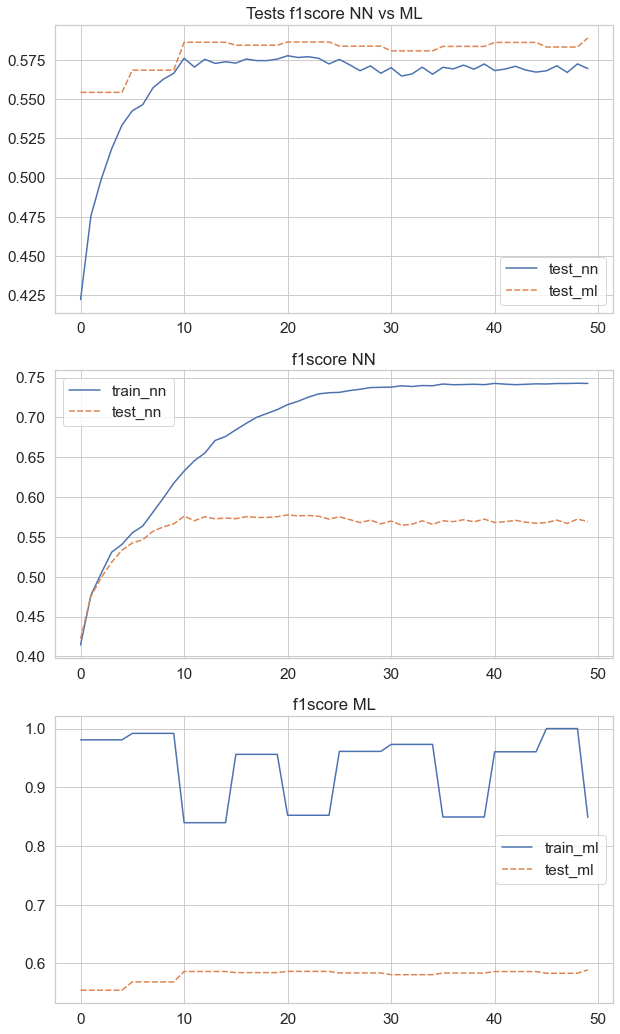

In [56]:
plot_metrics(rnnml_metrics_list, titles, metric_to_compare, drop_last=False)

# Summary

- 1st place - Tfidf + LogisticRegression (Macro F1 score on test data 0.6652)
- 2nd place - BOW + LogisticRegression (Macro F1 score on test data 0.6576)
- 3rd place - GloVe + RNN with XGBoost in the head (Macro F1 score on test data 0.5889)
- 4th place - GloVe + RNN with FC head (Macro F1 score on test data 0.5694)

Glove embeddings from 'glove-twitter-100' collection can be reason of too low score on RNN+ML algorithms. Embeddings from this set are lightweight, don't contain much words and can be easy processed on desktop PC. Larger embeddings sets can improve metric on the algorithms.